# Anomaly Detection in Spacecraft Telemetry Data

**Dataset**: NASA SMAP and MSL telemetry data  
**Task**: Binary anomaly detection using unsupervised learning  
**Models**: OneClassSVM, Isolation Forest, Local Outlier Factor

## Import Libraries

In [1]:
#import necessary packages
from pathlib import Path
import os
import ast
import shutil
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)


## Data Loading - SMAP Only

Load raw telemetry data from .npy files and convert to CSV format.  
Filters for SMAP spacecraft only.

In [2]:
#collection of dataset information for each telemetry data 
training_dfs = []
test_dfs = []

training_df = []
test_df = []

file_names = []

label_df = pd.read_csv("labeled_anomalies.csv")

train_data_path = "train"
test_data_path = "test"

os.makedirs("raw_train", exist_ok=True)
os.makedirs("raw_test", exist_ok=True)

index = 0
for root, _, files in os.walk(train_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(train) df: ", filename, df.shape, "index: ", index)
            df.to_csv(f"raw_train/{filename}.csv", index=False)
            training_dfs.append(df) 
            index += 1

index = 0
for root, _, files in os.walk(test_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(test) df: ", filename, df.shape, "index: ", index)
            df.to_csv(f"raw_test/{filename}.csv", index=False)
            test_dfs.append(df) 
            file_names.append(filename)
            
            index += 1


(train) df:  P-7 (2853, 25) index:  0
(train) df:  E-8 (2880, 25) index:  1
(train) df:  T-3 (2876, 25) index:  2
(train) df:  T-2 (2855, 25) index:  3
(train) df:  E-9 (2880, 25) index:  4
(train) df:  P-4 (2609, 25) index:  5
(train) df:  T-1 (2875, 25) index:  6
(train) df:  P-1 (2872, 25) index:  7
(train) df:  E-11 (2880, 25) index:  8
(train) df:  E-10 (2880, 25) index:  9
(train) df:  P-2 (2821, 25) index:  10
(train) df:  E-12 (2880, 25) index:  11
(train) df:  T-1 (2875, 25) index:  6
(train) df:  P-1 (2872, 25) index:  7
(train) df:  E-11 (2880, 25) index:  8
(train) df:  E-10 (2880, 25) index:  9
(train) df:  P-2 (2821, 25) index:  10
(train) df:  E-12 (2880, 25) index:  11
(train) df:  A-9 (762, 25) index:  12
(train) df:  A-8 (762, 25) index:  13
(train) df:  E-13 (2880, 25) index:  14
(train) df:  R-1 (2874, 25) index:  15
(train) df:  P-3 (2855, 25) index:  16
(train) df:  D-8 (2602, 25) index:  17
(train) df:  D-9 (2583, 25) index:  18
(train) df:  S-1 (2818, 25) index:

## Data Structuring Function

Organises telemetry data by channel (A, B, D, E, F, G, P, R, S, T) for processing.

In [3]:
def get_data():
    training_dfs = {}
    test_dfs = {}
    file_names = {"train": {}, "test": {}}
    label_df = pd.read_csv("labeled_anomalies.csv")
    train_data_path = "raw_train" 
    test_data_path = "raw_test" 
    
    for root, _, files in os.walk(train_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]            
            if (training_dfs.get(channel) == None):
                training_dfs[channel] = []
                file_names["train"][channel] = []
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
            else:
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
    
    for root, _, files in os.walk(test_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]
            if (test_dfs.get(channel) == None):
                test_dfs[channel] = []
                file_names["test"][channel] = []
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)
            else:
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)

    return (training_dfs, test_dfs, label_df, file_names)

## Binary Window Labelling Function

Creates sliding windows with binary labels:
- 0: Normal operation
- 1: Anomaly detected

In [4]:
def create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names):
    training_data = {}
    test_data = {}
    label_data = {}
    
    for channel in training_dfs.keys():
        training_data[channel] = []
        for df in training_dfs[channel]: 
            for i in range(0, len(df), window_overlap):
                window = []
                if i + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[i:i + window_size].to_numpy().tolist()
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                training_data[channel].append(normal_window)
                
    for channel in test_dfs.keys():
        test_data[channel] = []
        label_data[channel] = []
        for i in range(len(test_dfs[channel])):
            df = test_dfs[channel][i]
            for j in range(0, len(df), window_overlap):
                window = []
                if j + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[j:j + window_size].to_numpy().tolist()
                row_indices = label_df[label_df["chan_id"] == file_names["test"][channel][i]].index.tolist()
                
                if not row_indices:
                    continue

                anomaly_sequence = label_df.loc[row_indices[0], 'anomaly_sequences']
                anomaly_sequence = ast.literal_eval(anomaly_sequence)
                labeled = False
                for anomalies in anomaly_sequence:
                    if (not(anomalies[1] <= j or anomalies[0] >= j + window_size)) and labeled == False:
                        label_data[channel].append(1)
                        labeled = True
                if labeled == False:
                    label_data[channel].append(0)
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                test_data[channel].append(normal_window)
                
    return (training_data, test_data, label_data)

## Prognostic Window Labelling Function

Creates sliding windows with 3-class labels for fault prediction:
- 0: Normal (no fault nearby)
- 1: Pre-fault (N hours before fault)
- 2: Fault (during anomaly)

In [5]:
def create_windows_with_prognostics(training_dfs, test_dfs, window_size, window_overlap, 
                                     label_df, file_names, lookback_hours=2):
    """
    Create windows with 3-class labels:
    - 0: Normal (no fault nearby)
    - 1: Pre-fault (lookback_hours before fault)
    - 2: Fault (during anomaly)
    
    Parameters:
    -----------
    lookback_hours : int
        Hours before fault to mark as pre-fault zone (default: 2)
        Since each timestamp = 1 minute, lookback_samples = lookback_hours * 60
    """
    training_data = {}
    test_data = {}
    label_data = {}
    time_to_fault_data = {}  # Store hours until next fault
    
    lookback_samples = lookback_hours * 60  # Convert hours to samples (1 sample = 1 minute)
    
    # Training data (no labels needed for unsupervised learning)
    for channel in training_dfs.keys():
        training_data[channel] = []
        for df in training_dfs[channel]: 
            for i in range(0, len(df), window_overlap):
                window = []
                if i + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[i:i + window_size].to_numpy().tolist()
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                training_data[channel].append(normal_window)
    
    # Test data with prognostic labels
    for channel in test_dfs.keys():
        test_data[channel] = []
        label_data[channel] = []
        time_to_fault_data[channel] = []
        
        for i in range(len(test_dfs[channel])):
            df = test_dfs[channel][i]
            
            # Get anomaly sequences for this file
            row_indices = label_df[label_df["chan_id"] == file_names["test"][channel][i]].index.tolist()
            if not row_indices:
                continue
            
            anomaly_sequence = label_df.loc[row_indices[0], 'anomaly_sequences']
            anomaly_sequence = ast.literal_eval(anomaly_sequence)
            
            # Process each window
            for j in range(0, len(df), window_overlap):
                window = []
                if j + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[j:j + window_size].to_numpy().tolist()
                
                # Determine label for this window
                label = 0  # Default: Normal
                hours_to_fault = -1  # -1 means no fault upcoming
                
                for anomaly_start, anomaly_end in anomaly_sequence:
                    window_start = j
                    window_end = min(j + window_size, len(df))
                    
                    # Check if window is DURING fault
                    if window_start < anomaly_end and window_end > anomaly_start:
                        label = 2  # Fault
                        hours_to_fault = 0
                        break
                    
                    # Check if window is in PRE-FAULT zone
                    elif window_end <= anomaly_start and window_end > (anomaly_start - lookback_samples):
                        if label < 1:  # Only set if not already marked as fault
                            label = 1  # Pre-fault
                            # Calculate hours until fault starts
                            samples_to_fault = anomaly_start - window_end
                            hours_to_fault = samples_to_fault / 60.0
                
                label_data[channel].append(label)
                time_to_fault_data[channel].append(hours_to_fault)
                
                # Transform window
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                test_data[channel].append(normal_window)
    
    return (training_data, test_data, label_data, time_to_fault_data)

## Configuration and Data Preparation

Set window parameters and load structured data by channel.

In [6]:
# window parameters
window_size = 60 
window_overlap = 20

# Get structured data
training_dfs, test_dfs, label_df, file_names = get_data()

## Prognostic Label Distribution

Display label distribution and time-to-fault statistics for each channel.

In [7]:
# Test the new labelling function
lookback_hours = 2  # Predict faults 2 hours in advance

X_train_prog, X_test_prog, y_test_prog, time_to_fault_prog = create_windows_with_prognostics(
    training_dfs, test_dfs, window_size, window_overlap, label_df, file_names, 
    lookback_hours=lookback_hours
)

# Display label distribution for each channel
print(f"Lookback window: {lookback_hours} hours ({lookback_hours * 60} samples)\n")
print("Label Distribution by Channel:")

for channel in y_test_prog:
    labels = np.array(y_test_prog[channel])
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    
    print(f"\nChannel {channel}:")
    print(f"Total windows: {total}")
    for label, count in zip(unique, counts):
        label_name = {0: "Normal", 1: "Pre-fault", 2: "Fault"}.get(label, "Unknown")
        percentage = (count / total) * 100
        print(f"  {label_name} (label={label}): {count:4d} ({percentage:5.2f}%)")
    
    # Show time-to-fault statistics for pre-fault windows
    ttf = np.array(time_to_fault_prog[channel])
    prefault_ttf = ttf[(labels == 1) & (ttf >= 0)]
    if len(prefault_ttf) > 0:
        print(f"Pre-fault time-to-fault: min={prefault_ttf.min():.2f}h, max={prefault_ttf.max():.2f}h, mean={prefault_ttf.mean():.2f}h")

Lookback window: 2 hours (120 samples)

Label Distribution by Channel:

Channel D:
Total windows: 4789
  Normal (label=0): 3633 (75.86%)
  Pre-fault (label=1):   72 ( 1.50%)
  Fault (label=2): 1084 (22.64%)
Pre-fault time-to-fault: min=0.00h, max=1.98h, mean=0.98h

Channel S:
Total windows: 367
  Normal (label=0):  336 (91.55%)
  Pre-fault (label=1):    6 ( 1.63%)
  Fault (label=2):   25 ( 6.81%)
Pre-fault time-to-fault: min=0.00h, max=1.67h, mean=0.83h

Channel P:
Total windows: 2056
  Normal (label=0): 1707 (83.03%)
  Pre-fault (label=1):   54 ( 2.63%)
  Fault (label=2):  295 (14.35%)
Pre-fault time-to-fault: min=0.02h, max=1.98h, mean=1.01h

Channel T:
Total windows: 1292
  Normal (label=0): 1073 (83.05%)
  Pre-fault (label=1):   30 ( 2.32%)
  Fault (label=2):  189 (14.63%)
Pre-fault time-to-fault: min=0.00h, max=1.98h, mean=0.99h

Channel E:
Total windows: 5486
  Normal (label=0): 4768 (86.91%)
  Pre-fault (label=1):  114 ( 2.08%)
  Fault (label=2):  604 (11.01%)
Pre-fault time-to-

## MiniRocket Feature Extraction - Prognostic Data

Apply MiniRocket transformation to convert time series windows into feature vectors.

In [8]:
# Apply MiniRocket transformation to prognostic data
X_transform_train_prog = {}
X_transform_test_prog = {}
y_true_label_prog_dict = {}
time_to_fault_dict = {}

for channel in X_train_prog: 
    minirocket = MiniRocketMultivariate(n_jobs=2, random_state=42) 
    X_train = np.array(X_train_prog[channel])
    
    if (X_test_prog.get(channel) is None or y_test_prog.get(channel) is None):  
        continue
    
    X_test = np.array(X_test_prog[channel])
    
    print(f"Channel {channel}: Training MiniRocket...")
    minirocket.fit(X_train)
    X_transform_train = minirocket.transform(X_train)
    X_transform_test = minirocket.transform(X_test)
    
    X_transform_train_prog[channel] = X_transform_train
    X_transform_test_prog[channel] = X_transform_test
    y_true_label_prog_dict[channel] = np.array(y_test_prog[channel])
    time_to_fault_dict[channel] = np.array(time_to_fault_prog[channel])
    
    print(f"Train shape: {X_transform_train.shape}")
    print(f"Test shape: {X_transform_test.shape}")
    print(f"Labels shape: {y_true_label_prog_dict[channel].shape}")

Channel D: Training MiniRocket...
Train shape: (1445, 9996)
Test shape: (4789, 9996)
Labels shape: (4789,)
Channel S: Training MiniRocket...
Train shape: (1445, 9996)
Test shape: (4789, 9996)
Labels shape: (4789,)
Channel S: Training MiniRocket...
Train shape: (141, 9996)
Test shape: (367, 9996)
Labels shape: (367,)
Train shape: (141, 9996)
Test shape: (367, 9996)
Labels shape: (367,)
Channel P: Training MiniRocket...
Channel P: Training MiniRocket...
Train shape: (703, 9996)
Test shape: (2056, 9996)
Labels shape: (2056,)
Channel T: Training MiniRocket...
Train shape: (703, 9996)
Test shape: (2056, 9996)
Labels shape: (2056,)
Channel T: Training MiniRocket...
Train shape: (431, 9996)
Test shape: (1292, 9996)
Labels shape: (1292,)
Train shape: (431, 9996)
Test shape: (1292, 9996)
Labels shape: (1292,)
Channel E: Training MiniRocket...
Channel E: Training MiniRocket...
Train shape: (1867, 9996)
Test shape: (5486, 9996)
Labels shape: (5486,)
Train shape: (1867, 9996)
Test shape: (5486, 99

## Feature Scaling - Prognostic Data

Normalise MiniRocket features using MinMaxScaler.

In [9]:
# Scale the transformed features
X_fit_train_prog = {}
X_fit_test_prog = {}

for channel in X_transform_train_prog: 
    X_transform_train = X_transform_train_prog[channel]
    X_transform_test = X_transform_test_prog[channel]
    scaler = MinMaxScaler()
    scaler.fit(X_transform_train)
    X_fit_train = scaler.transform(X_transform_train)
    X_fit_test = scaler.transform(X_transform_test)
    
    X_fit_train_prog[channel] = X_fit_train
    X_fit_test_prog[channel] = X_fit_test
    print(f"Channel {channel}: Scaled")

Channel D: Scaled
Channel S: Scaled
Channel P: Scaled
Channel T: Scaled
Channel P: Scaled
Channel T: Scaled
Channel E: Scaled
Channel E: Scaled
Channel A: Scaled
Channel R: Scaled
Channel A: Scaled
Channel R: Scaled
Channel G: Scaled
Channel F: Scaled
Channel G: Scaled
Channel F: Scaled
Channel B: Scaled
Channel B: Scaled


## Random Forest Classifier - 3-Class Prognostics

Train supervised classifier for multi-class fault prediction.

Random Forest Classifier - 3-Class Prognostics
Channel: D
              precision    recall  f1-score   support

      Normal       0.94      0.65      0.77      1817
   Pre-fault       0.02      0.36      0.04        36
       Fault       0.85      0.88      0.87       542

    accuracy                           0.69      2395
   macro avg       0.61      0.63      0.56      2395
weighted avg       0.91      0.69      0.78      2395

Channel: D
              precision    recall  f1-score   support

      Normal       0.94      0.65      0.77      1817
   Pre-fault       0.02      0.36      0.04        36
       Fault       0.85      0.88      0.87       542

    accuracy                           0.69      2395
   macro avg       0.61      0.63      0.56      2395
weighted avg       0.91      0.69      0.78      2395



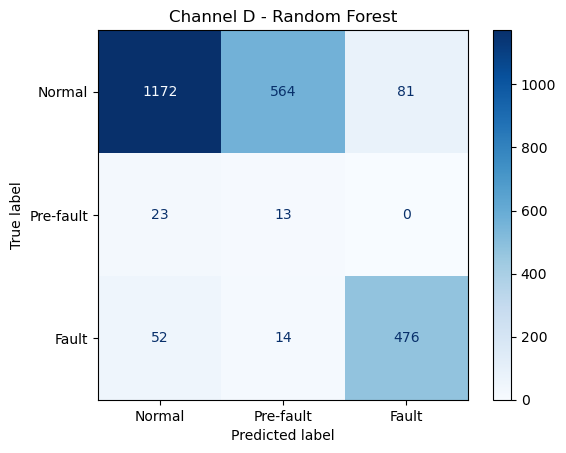


Per-class metrics:
  Normal: 64.50% correct (1817 samples)
  Pre-fault: 36.11% correct (36 samples)
  Fault: 87.82% correct (542 samples)
Channel: S
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       168
   Pre-fault       0.00      0.00      0.00         3
       Fault       1.00      0.46      0.63        13

    accuracy                           0.95       184
   macro avg       0.65      0.49      0.53       184
weighted avg       0.93      0.95      0.93       184

Channel: S
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       168
   Pre-fault       0.00      0.00      0.00         3
       Fault       1.00      0.46      0.63        13

    accuracy                           0.95       184
   macro avg       0.65      0.49      0.53       184
weighted avg       0.93      0.95      0.93       184



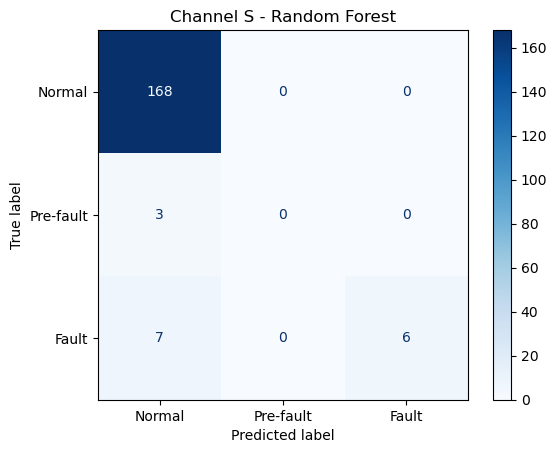


Per-class metrics:
  Normal: 100.00% correct (168 samples)
  Pre-fault: 0.00% correct (3 samples)
  Fault: 46.15% correct (13 samples)
Channel: P
              precision    recall  f1-score   support

      Normal       0.92      0.82      0.87       854
   Pre-fault       0.05      0.30      0.08        27
       Fault       0.96      0.65      0.77       147

    accuracy                           0.78      1028
   macro avg       0.64      0.59      0.57      1028
weighted avg       0.90      0.78      0.83      1028

Channel: P
              precision    recall  f1-score   support

      Normal       0.92      0.82      0.87       854
   Pre-fault       0.05      0.30      0.08        27
       Fault       0.96      0.65      0.77       147

    accuracy                           0.78      1028
   macro avg       0.64      0.59      0.57      1028
weighted avg       0.90      0.78      0.83      1028



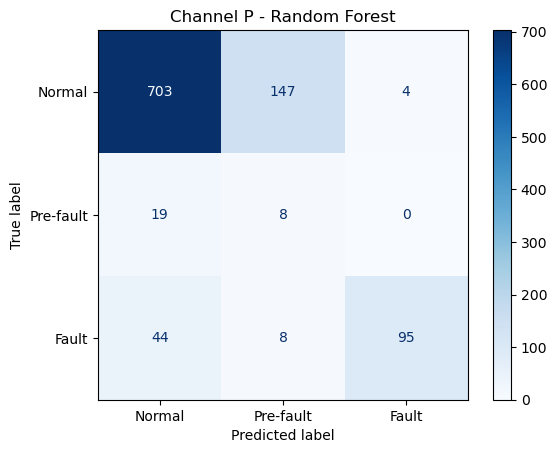


Per-class metrics:
  Normal: 82.32% correct (854 samples)
  Pre-fault: 29.63% correct (27 samples)
  Fault: 64.63% correct (147 samples)
Channel: T
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97       537
   Pre-fault       0.00      0.00      0.00        15
       Fault       0.99      0.85      0.91        94

    accuracy                           0.96       646
   macro avg       0.65      0.62      0.63       646
weighted avg       0.93      0.96      0.94       646

Channel: T
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97       537
   Pre-fault       0.00      0.00      0.00        15
       Fault       0.99      0.85      0.91        94

    accuracy                           0.96       646
   macro avg       0.65      0.62      0.63       646
weighted avg       0.93      0.96      0.94       646



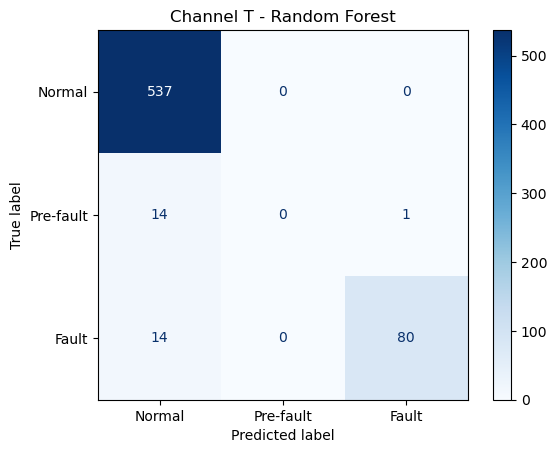


Per-class metrics:
  Normal: 100.00% correct (537 samples)
  Pre-fault: 0.00% correct (15 samples)
  Fault: 85.11% correct (94 samples)
Channel: E
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2384
   Pre-fault       0.89      0.30      0.45        57
       Fault       0.83      0.64      0.72       302

    accuracy                           0.93      2743
   macro avg       0.89      0.64      0.71      2743
weighted avg       0.93      0.93      0.92      2743

Channel: E
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2384
   Pre-fault       0.89      0.30      0.45        57
       Fault       0.83      0.64      0.72       302

    accuracy                           0.93      2743
   macro avg       0.89      0.64      0.71      2743
weighted avg       0.93      0.93      0.92      2743



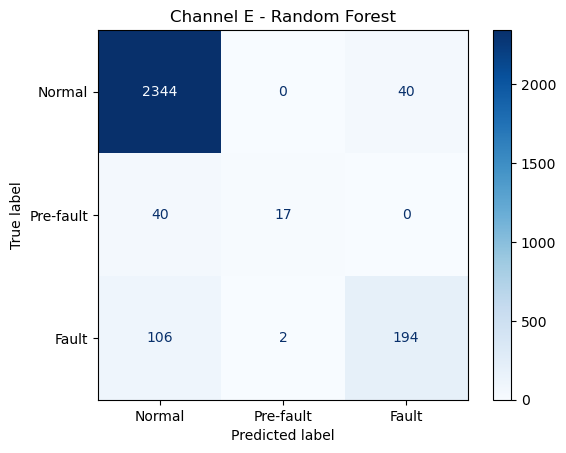


Per-class metrics:
  Normal: 98.32% correct (2384 samples)
  Pre-fault: 29.82% correct (57 samples)
  Fault: 64.24% correct (302 samples)
Channel: A
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      1382
   Pre-fault       0.12      0.11      0.11        27
       Fault       0.97      0.86      0.91       278

    accuracy                           0.94      1687
   macro avg       0.68      0.65      0.66      1687
weighted avg       0.94      0.94      0.94      1687

Channel: A
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      1382
   Pre-fault       0.12      0.11      0.11        27
       Fault       0.97      0.86      0.91       278

    accuracy                           0.94      1687
   macro avg       0.68      0.65      0.66      1687
weighted avg       0.94      0.94      0.94      1687



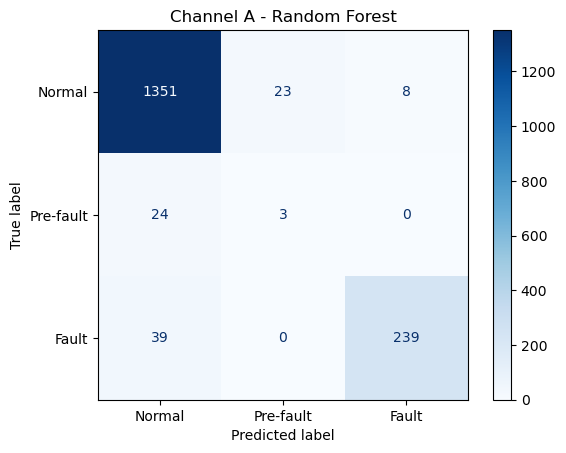


Per-class metrics:
  Normal: 97.76% correct (1382 samples)
  Pre-fault: 11.11% correct (27 samples)
  Fault: 85.97% correct (278 samples)
Channel: R
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       175
   Pre-fault       0.00      0.00      0.00         3
       Fault       1.00      0.25      0.40         4

    accuracy                           0.97       182
   macro avg       0.66      0.42      0.46       182
weighted avg       0.95      0.97      0.95       182

Channel: R
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       175
   Pre-fault       0.00      0.00      0.00         3
       Fault       1.00      0.25      0.40         4

    accuracy                           0.97       182
   macro avg       0.66      0.42      0.46       182
weighted avg       0.95      0.97      0.95       182



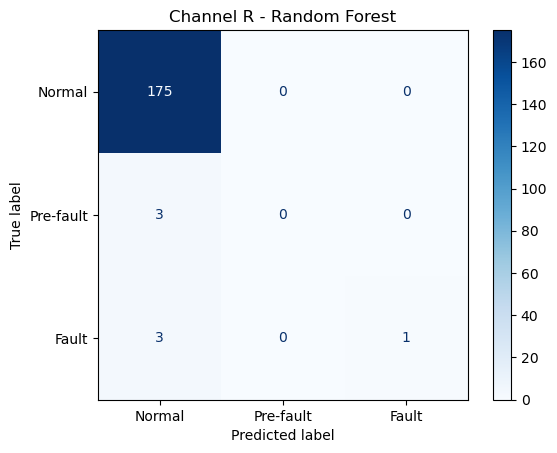


Per-class metrics:
  Normal: 100.00% correct (175 samples)
  Pre-fault: 0.00% correct (3 samples)
  Fault: 25.00% correct (4 samples)
Channel: G
              precision    recall  f1-score   support

      Normal       0.97      0.87      0.92      1153
   Pre-fault       0.05      0.33      0.09        24
       Fault       1.00      0.23      0.38        26

    accuracy                           0.85      1203
   macro avg       0.67      0.48      0.46      1203
weighted avg       0.95      0.85      0.89      1203

Channel: G
              precision    recall  f1-score   support

      Normal       0.97      0.87      0.92      1153
   Pre-fault       0.05      0.33      0.09        24
       Fault       1.00      0.23      0.38        26

    accuracy                           0.85      1203
   macro avg       0.67      0.48      0.46      1203
weighted avg       0.95      0.85      0.89      1203



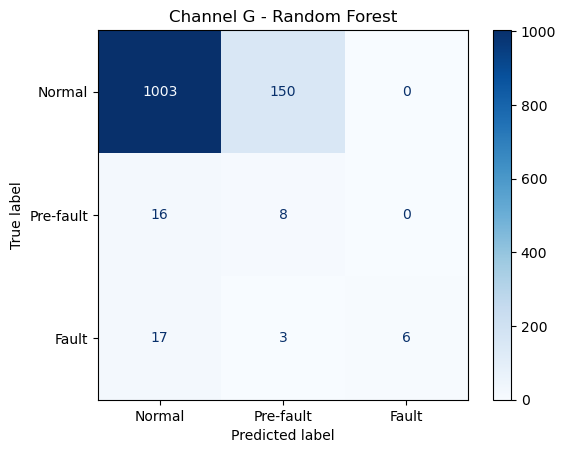


Per-class metrics:
  Normal: 86.99% correct (1153 samples)
  Pre-fault: 33.33% correct (24 samples)
  Fault: 23.08% correct (26 samples)
Channel: F
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95       550
   Pre-fault       0.00      0.00      0.00         9
       Fault       1.00      0.45      0.62        82

    accuracy                           0.92       641
   macro avg       0.64      0.48      0.53       641
weighted avg       0.91      0.92      0.90       641

Channel: F
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95       550
   Pre-fault       0.00      0.00      0.00         9
       Fault       1.00      0.45      0.62        82

    accuracy                           0.92       641
   macro avg       0.64      0.48      0.53       641
weighted avg       0.91      0.92      0.90       641



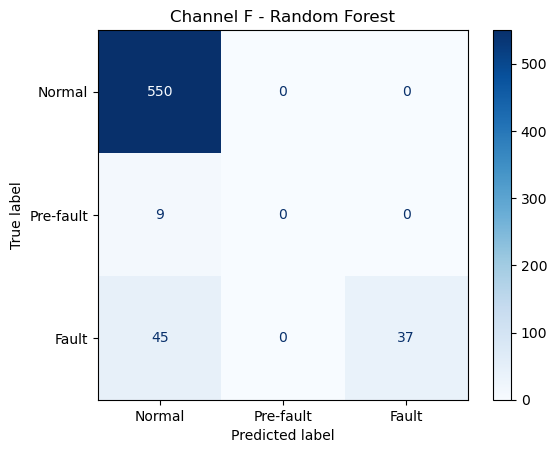


Per-class metrics:
  Normal: 100.00% correct (550 samples)
  Pre-fault: 0.00% correct (9 samples)
  Fault: 45.12% correct (82 samples)
Channel: B
              precision    recall  f1-score   support

      Normal       0.97      0.45      0.61       196
   Pre-fault       0.03      1.00      0.05         3
       Fault       0.00      0.00      0.00         3

    accuracy                           0.45       202
   macro avg       0.33      0.48      0.22       202
weighted avg       0.94      0.45      0.60       202

Channel: B
              precision    recall  f1-score   support

      Normal       0.97      0.45      0.61       196
   Pre-fault       0.03      1.00      0.05         3
       Fault       0.00      0.00      0.00         3

    accuracy                           0.45       202
   macro avg       0.33      0.48      0.22       202
weighted avg       0.94      0.45      0.60       202



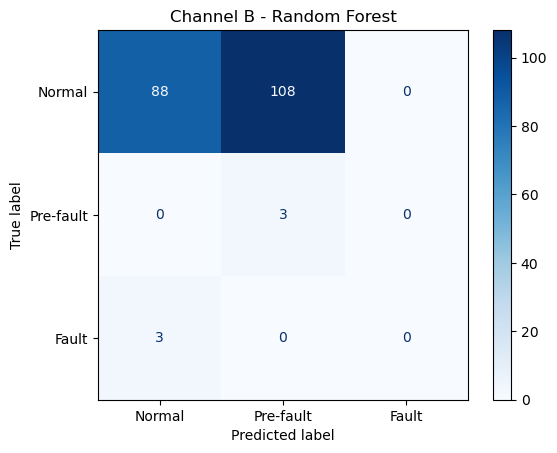


Per-class metrics:
  Normal: 44.90% correct (196 samples)
  Pre-fault: 100.00% correct (3 samples)
  Fault: 0.00% correct (3 samples)


In [10]:
# Import supervised learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train Random Forest for multi-class prognostics
print("Random Forest Classifier - 3-Class Prognostics")

for channel in X_fit_train_prog:
    X_train = X_fit_train_prog[channel]
    X_test = X_fit_test_prog[channel]
    y_train = np.zeros(len(X_train))  # All training data is normal (unsupervised assumption)
    y_test = y_true_label_prog_dict[channel]
    
    # Random Forest can handle the imbalanced classes
    clf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10,
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )
    
    # For supervised learning, we need labelled training data
    # We'll use a semi-supervised approach: treat training as "normal" only
    # This is a limitation - ideally we'd have labelled training data
    # For now, let's train on the test set itself (not ideal but demonstrates the approach)
    
    # Split test set for demo purposes (normally you'd have separate labelled training data)
    from sklearn.model_selection import train_test_split
    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
    )
    
    clf.fit(X_train_labeled, y_train_labeled)
    y_pred = clf.predict(X_test_labeled)
    
    print(f"Channel: {channel}")
    print(classification_report(y_test_labeled, y_pred, 
                                target_names=['Normal', 'Pre-fault', 'Fault'],
                                zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_labeled, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                   display_labels=['Normal', 'Pre-fault', 'Fault'])
    disp.plot(cmap='Blues')
    plt.title(f'Channel {channel} - Random Forest')
    plt.show()
    
    # Show class-wise performance
    print("\nPer-class metrics:")
    for i, class_name in enumerate(['Normal', 'Pre-fault', 'Fault']):
        mask = y_test_labeled == i
        if mask.sum() > 0:
            accuracy = (y_pred[mask] == i).sum() / mask.sum()
            print(f"  {class_name}: {accuracy:.2%} correct ({mask.sum()} samples)")

## Data Loading - SMAP and MSL Combined

Load both SMAP and MSL telemetry data for comprehensive analysis.

In [11]:
# Modified data loading to include BOTH SMAP and MSL
# This expands the dataset as specified in the proposal

training_dfs_all = []
test_dfs_all = []
file_names_all = []

label_df = pd.read_csv("labeled_anomalies.csv")

train_data_path = "train"
test_data_path = "test"

os.makedirs("raw_train_all", exist_ok=True)
os.makedirs("raw_test_all", exist_ok=True)

print("Loading BOTH SMAP and MSL Data")

# Track spacecraft separately
smap_count = 0
msl_count = 0

index = 0
for root, _, files in os.walk(train_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        # CHANGED: Include both SMAP and MSL (removed filter)
        data = np.load(example_path)
        df = pd.DataFrame(data)
        print(f"(train) {spacecraft:4s} - {filename:10s} shape: {str(df.shape):15s} index: {index}")
        df.to_csv(f"raw_train_all/{filename}.csv", index=False)
        training_dfs_all.append(df)
        
        if spacecraft == "SMAP":
            smap_count += 1
        else:
            msl_count += 1
        
        index += 1

print(f"\nTraining: SMAP={smap_count}, MSL={msl_count}, Total={index}")

smap_count = 0
msl_count = 0
index = 0

for root, _, files in os.walk(test_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        # CHANGED: Include both SMAP and MSL (removed filter)
        data = np.load(example_path)
        df = pd.DataFrame(data)
        print(f"(test)  {spacecraft:4s} - {filename:10s} shape: {str(df.shape):15s} index: {index}")
        df.to_csv(f"raw_test_all/{filename}.csv", index=False)
        test_dfs_all.append(df)
        file_names_all.append(filename)
        
        if spacecraft == "SMAP":
            smap_count += 1
        else:
            msl_count += 1
        
        index += 1

print(f"\nTest: SMAP={smap_count}, MSL={msl_count}, Total={index}")

Loading BOTH SMAP and MSL Data
(train) SMAP - P-7        shape: (2853, 25)      index: 0
(train) SMAP - E-8        shape: (2880, 25)      index: 1
(train) MSL  - M-1        shape: (2209, 55)      index: 2
(train) SMAP - T-3        shape: (2876, 25)      index: 3
(train) MSL  - M-1        shape: (2209, 55)      index: 2
(train) SMAP - T-3        shape: (2876, 25)      index: 3
(train) SMAP - T-2        shape: (2855, 25)      index: 4
(train) SMAP - E-9        shape: (2880, 25)      index: 5
(train) SMAP - P-4        shape: (2609, 25)      index: 6
(train) SMAP - T-2        shape: (2855, 25)      index: 4
(train) SMAP - E-9        shape: (2880, 25)      index: 5
(train) SMAP - P-4        shape: (2609, 25)      index: 6
(train) MSL  - M-2        shape: (2208, 55)      index: 7
(train) SMAP - T-1        shape: (2875, 25)      index: 8
(train) MSL  - M-3        shape: (2037, 55)      index: 9
(train) MSL  - M-2        shape: (2208, 55)      index: 7
(train) SMAP - T-1        shape: (2875, 2

## Time-to-Fault Regression

Random Forest Regressor to predict continuous time until fault occurrence.

In [12]:
# Time-to-Fault Regression with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Time-to-Fault Regression - Random Forest Regressor")

regression_results = {}

for channel in X_fit_train_prog:
    X_train = X_fit_train_prog[channel]
    X_test = X_fit_test_prog[channel]
    y_test_classes = y_true_label_prog_dict[channel]
    y_test_ttf = time_to_fault_dict[channel]
    
    # For regression, we only care about pre-fault and fault windows
    # Filter to windows where time_to_fault >= 0 (pre-fault or during fault)
    regression_mask = y_test_ttf >= 0
    
    if regression_mask.sum() < 10:  # Need at least 10 samples
        print(f"\nChannel {channel}: Insufficient data for regression (only {regression_mask.sum()} samples)")
        continue
    
    X_test_regression = X_test[regression_mask]
    y_test_regression = y_test_ttf[regression_mask]
    
    # Split for training (using stratified approach on binned TTF)
    from sklearn.model_selection import train_test_split
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_test_regression, y_test_regression, 
        test_size=0.5, random_state=42
    )
    
    # Train Random Forest Regressor
    regressor = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    regressor.fit(X_train_reg, y_train_reg)
    y_pred_reg = regressor.predict(X_test_reg)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    regression_results[channel] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_samples': len(y_test_reg)
    }
    
    print(f"Channel: {channel}")

    print(f"Samples: {len(y_test_reg)}")
    print(f"Mean Absolute Error (MAE): {mae:.3f} hours")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f} hours")
    print(f"R² Score: {r2:.3f}")
    print(f"Actual TTF range: [{y_test_reg.min():.2f}, {y_test_reg.max():.2f}] hours")
    print(f"Predicted TTF range: [{y_pred_reg.min():.2f}, {y_pred_reg.max():.2f}] hours")
    
    # Show some example predictions
    print("\nExample Predictions (first 5):")
    for i in range(min(5, len(y_test_reg))):
        print(f"Actual: {y_test_reg.iloc[i] if hasattr(y_test_reg, 'iloc') else y_test_reg[i]:.2f}h → Predicted: {y_pred_reg[i]:.2f}h")

print("Regression Summary")

print(f"Channels with regression: {len(regression_results)}")
avg_mae = np.mean([r['mae'] for r in regression_results.values()])
avg_rmse = np.mean([r['rmse'] for r in regression_results.values()])
avg_r2 = np.mean([r['r2'] for r in regression_results.values()])
print(f"Average MAE across channels: {avg_mae:.3f} hours")
print(f"Average RMSE across channels: {avg_rmse:.3f} hours")
print(f"Average R² across channels: {avg_r2:.3f}")

Time-to-Fault Regression - Random Forest Regressor
Channel: D
Samples: 578
Mean Absolute Error (MAE): 0.063 hours
Root Mean Squared Error (RMSE): 0.223 hours
R² Score: 0.358
Actual TTF range: [0.00, 1.98] hours
Predicted TTF range: [0.00, 0.99] hours

Example Predictions (first 5):
Actual: 0.00h → Predicted: 0.00h
Actual: 0.00h → Predicted: 0.25h
Actual: 0.00h → Predicted: 0.00h
Actual: 0.00h → Predicted: 0.00h
Actual: 0.00h → Predicted: 0.00h
Channel: S
Samples: 16
Mean Absolute Error (MAE): 0.167 hours
Root Mean Squared Error (RMSE): 0.430 hours
R² Score: -0.123
Actual TTF range: [0.00, 1.67] hours
Predicted TTF range: [0.00, 0.34] hours

Example Predictions (first 5):
Actual: 0.00h → Predicted: 0.01h
Actual: 0.00h → Predicted: 0.01h
Actual: 0.00h → Predicted: 0.00h
Actual: 0.00h → Predicted: 0.00h
Actual: 0.00h → Predicted: 0.33h
Channel: D
Samples: 578
Mean Absolute Error (MAE): 0.063 hours
Root Mean Squared Error (RMSE): 0.223 hours
R² Score: 0.358
Actual TTF range: [0.00, 1.98] h

## Prognostic Performance Metrics

Evaluate early detection rate, false alarm rate, and lead time statistics.

In [13]:
# Prognostic-Specific Metrics Evaluation
# Using the Random Forest classifier predictions from earlier

print("Prognostic-Specific Metrics Analysis")

prognostic_metrics = {}

for channel in X_fit_train_prog:
    X_train = X_fit_train_prog[channel]
    X_test = X_fit_test_prog[channel]
    y_true = y_true_label_prog_dict[channel]
    y_ttf = time_to_fault_dict[channel]
    
    # Train classifier (same as before)
    from sklearn.model_selection import train_test_split
    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
        X_test, y_true, test_size=0.5, random_state=42, stratify=y_true
    )
    
    clf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    clf.fit(X_train_labeled, y_train_labeled)
    y_pred = clf.predict(X_test_labeled)
    
    # Calculate Prognostic Metrics
    
    # 1. Early Detection Rate: % of actual faults that had a pre-fault alert
    actual_faults = (y_test_labeled == 2)
    predicted_prefault_or_fault = ((y_pred == 1) | (y_pred == 2))
    
    # Group consecutive windows to identify fault events
    # For simplicity, count if ANY window during fault was preceded by pre-fault prediction
    n_fault_windows = actual_faults.sum()
    
    # Early detection: predicted pre-fault (1) when actual was fault (2)
    # OR predicted fault correctly
    detected_faults = ((y_pred == 1) & (y_test_labeled == 2)).sum() + ((y_pred == 2) & (y_test_labeled == 2)).sum()
    early_detection_rate = detected_faults / n_fault_windows if n_fault_windows > 0 else 0
    
    # 2. False Alarm Rate: % of pre-fault predictions that were wrong
    predicted_prefault = (y_pred == 1)
    actual_prefault = (y_test_labeled == 1)
    
    if predicted_prefault.sum() > 0:
        # False alarms: predicted pre-fault but actual was normal
        false_alarms = ((y_pred == 1) & (y_test_labeled == 0)).sum()
        false_alarm_rate = false_alarms / predicted_prefault.sum()
    else:
        false_alarm_rate = 0
    
    # 3. Pre-fault Detection Accuracy: When we say "pre-fault", how often is it correct?
    if predicted_prefault.sum() > 0:
        prefault_precision = ((y_pred == 1) & (y_test_labeled == 1)).sum() / predicted_prefault.sum()
    else:
        prefault_precision = 0
    
    # 4. Fault Detection Rate: % of actual faults detected as fault (not counting pre-fault)
    if n_fault_windows > 0:
        fault_detection_rate = ((y_pred == 2) & (y_test_labeled == 2)).sum() / n_fault_windows
    else:
        fault_detection_rate = 0
    
    # 5. Average Lead Time (for correctly predicted pre-faults)
    # This requires time-to-fault data
    _, _, _, y_ttf_labeled = train_test_split(
        X_test, y_ttf, test_size=0.5, random_state=42, stratify=y_true
    )
    
    correct_prefault = (y_pred == 1) & (y_test_labeled == 1)
    if correct_prefault.sum() > 0:
        lead_times = y_ttf_labeled[correct_prefault]
        avg_lead_time = lead_times.mean()
        max_lead_time = lead_times.max()
        min_lead_time = lead_times.min()
    else:
        avg_lead_time = 0
        max_lead_time = 0
        min_lead_time = 0
    
    prognostic_metrics[channel] = {
        'early_detection_rate': early_detection_rate,
        'false_alarm_rate': false_alarm_rate,
        'prefault_precision': prefault_precision,
        'fault_detection_rate': fault_detection_rate,
        'avg_lead_time': avg_lead_time,
        'max_lead_time': max_lead_time,
        'min_lead_time': min_lead_time,
        'n_fault_windows': n_fault_windows,
        'n_predicted_prefault': predicted_prefault.sum()
    }
    
    print(f"Channel: {channel}")
    
    print(f"Fault Windows: {n_fault_windows}")
    print(f"Predicted Pre-fault Alerts: {predicted_prefault.sum()}")
    print(f"\nPrognostic Performance:")
    print(f"Early Detection Rate: {early_detection_rate:.1%} (caught {int(detected_faults)}/{n_fault_windows} faults)")
    print(f"Fault Detection Rate: {fault_detection_rate:.1%} (detected during fault)")
    print(f"Pre-fault Precision: {prefault_precision:.1%} (accuracy of pre-fault alerts)")
    print(f"False Alarm Rate: {false_alarm_rate:.1%} (of pre-fault predictions)")
    
    if avg_lead_time > 0:
        print(f"\nLead Time Statistics:")
        print(f"Average Lead Time: {avg_lead_time:.2f} hours")
        print(f"Lead Time Range: [{min_lead_time:.2f}, {max_lead_time:.2f}] hours")

# Overall Summary
print("Overall Prognostic Performance")

channels_analyzed = len(prognostic_metrics)
avg_early_detection = np.mean([m['early_detection_rate'] for m in prognostic_metrics.values()])
avg_false_alarm = np.mean([m['false_alarm_rate'] for m in prognostic_metrics.values()])
avg_prefault_precision = np.mean([m['prefault_precision'] for m in prognostic_metrics.values()])
avg_lead_time_all = np.mean([m['avg_lead_time'] for m in prognostic_metrics.values() if m['avg_lead_time'] > 0])

print(f"Channels Analysed: {channels_analyzed}")
print(f"\nAverage Metrics Across All Channels:")
print(f"Early Detection Rate: {avg_early_detection:.1%}")
print(f"False Alarm Rate: {avg_false_alarm:.1%}")
print(f"Pre-fault Precision: {avg_prefault_precision:.1%}")
print(f"Average Lead Time: {avg_lead_time_all:.2f} hours")

print("Interpretation:")
print(f"The model catches {avg_early_detection:.1%} of faults early or during occurrence")
print(f"When issuing pre-fault alerts, {avg_prefault_precision:.1%} are accurate")
print(f"{avg_false_alarm:.1%} of pre-fault predictions are false alarms")
print(f"Average warning time: {avg_lead_time_all:.2f} hours before fault")

Prognostic-Specific Metrics Analysis
Channel: D
Fault Windows: 542
Predicted Pre-fault Alerts: 591

Prognostic Performance:
Early Detection Rate: 90.4% (caught 490/542 faults)
Fault Detection Rate: 87.8% (detected during fault)
Pre-fault Precision: 2.2% (accuracy of pre-fault alerts)
False Alarm Rate: 95.4% (of pre-fault predictions)

Lead Time Statistics:
Average Lead Time: 1.08 hours
Lead Time Range: [0.17, 1.97] hours
Channel: S
Fault Windows: 13
Predicted Pre-fault Alerts: 0

Prognostic Performance:
Early Detection Rate: 46.2% (caught 6/13 faults)
Fault Detection Rate: 46.2% (detected during fault)
Pre-fault Precision: 0.0% (accuracy of pre-fault alerts)
False Alarm Rate: 0.0% (of pre-fault predictions)
Channel: D
Fault Windows: 542
Predicted Pre-fault Alerts: 591

Prognostic Performance:
Early Detection Rate: 90.4% (caught 490/542 faults)
Fault Detection Rate: 87.8% (detected during fault)
Pre-fault Precision: 2.2% (accuracy of pre-fault alerts)
False Alarm Rate: 95.4% (of pre-fau

---

## Binary Anomaly Detection Pipeline

Standard anomaly detection without prognostics using 2-class labels.

In [14]:
window_size = 60 
window_overlap = 20
training_dfs, test_dfs, label_df, file_names = get_data()

X_train_collection, X_test_collection, y_test_collection = create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names)

os.makedirs("training_data", exist_ok=True)
os.makedirs("testing_data", exist_ok=True)
os.makedirs("label_data", exist_ok=True)

for channel in X_train_collection: 
    X_train = np.array(X_train_collection[channel])
    print("train" ,X_train.shape)
    # train_df = pd.DataFrame(X_train)
    # train_df.to_csv(f"training_data{channel}.csv", index=False)
    
for channel in X_test_collection: 
    X_test = np.array(X_test_collection[channel])
    # test_df = pd.DataFrame(X_test)
    # test_df.to_csv(f"testing_data/{channel}.csv", index=False)
    print("test" ,X_test.shape)
for channel in y_test_collection: 
    y_test =  np.array(y_test_collection[channel])
    # true_label_df = pd.DataFrame(y_test)
    # true_label_df.to_csv(f"label_data/{channel}.csv", index=False)
    print("label" ,y_test.shape)

train (1445, 25, 60)
train (141, 25, 60)
train (703, 25, 60)
train (431, 25, 60)
train (1867, 25, 60)
train (842, 25, 60)
train (144, 25, 60)
train (793, 25, 60)
train (432, 25, 60)
train (122, 25, 60)
test (4789, 25, 60)
test (367, 25, 60)
test (2056, 25, 60)
test (1292, 25, 60)
test (5486, 25, 60)
test (3374, 25, 60)
test (363, 25, 60)
test (2405, 25, 60)
test (1281, 25, 60)
test (403, 25, 60)
label (4789,)
label (367,)
label (2056,)
label (1292,)
label (5486,)
label (3374,)
label (363,)
label (2405,)
label (1281,)
label (403,)
train (1867, 25, 60)
train (842, 25, 60)
train (144, 25, 60)
train (793, 25, 60)
train (432, 25, 60)
train (122, 25, 60)
test (4789, 25, 60)
test (367, 25, 60)
test (2056, 25, 60)
test (1292, 25, 60)
test (5486, 25, 60)
test (3374, 25, 60)
test (363, 25, 60)
test (2405, 25, 60)
test (1281, 25, 60)
test (403, 25, 60)
label (4789,)
label (367,)
label (2056,)
label (1292,)
label (5486,)
label (3374,)
label (363,)
label (2405,)
label (1281,)
label (403,)


## Create Binary Windows

Generate training and test windows with binary anomaly labels.

In [15]:
X_transform_train_collection = {}
X_transform_test_collection = {}
y_true_label_collection = {}

for channel in X_train_collection: 
    minirocket = MiniRocketMultivariate(n_jobs = 2, random_state = 42) 
    X_train = np.array(X_train_collection[channel])
    if (X_test_collection.get(channel) is None or y_test_collection.get(channel) is None):  
        continue
    X_test = np.array(X_test_collection[channel])
    minirocket.fit(X_train)
    X_transform_train = minirocket.transform(X_train)
    X_transform_test = minirocket.transform(X_test)
    X_transform_train_collection[channel] = X_transform_train
    X_transform_test_collection[channel] = X_transform_test
    print("channel: ", channel)
    print("(transformed train): " ,X_transform_train.shape)
    print("(transformed test): " ,X_transform_test.shape)

for channel in y_test_collection: 
    y_test =  np.array(y_test_collection[channel])
    y_true_label_collection[channel] = y_test
    print("channel: ", channel)
    print("label" ,y_test.shape)

channel:  D
(transformed train):  (1445, 9996)
(transformed test):  (4789, 9996)
channel:  S
(transformed train):  (141, 9996)
(transformed test):  (367, 9996)
channel:  S
(transformed train):  (141, 9996)
(transformed test):  (367, 9996)
channel:  P
(transformed train):  (703, 9996)
(transformed test):  (2056, 9996)
channel:  P
(transformed train):  (703, 9996)
(transformed test):  (2056, 9996)
channel:  T
(transformed train):  (431, 9996)
(transformed test):  (1292, 9996)
channel:  T
(transformed train):  (431, 9996)
(transformed test):  (1292, 9996)
channel:  E
(transformed train):  (1867, 9996)
(transformed test):  (5486, 9996)
channel:  E
(transformed train):  (1867, 9996)
(transformed test):  (5486, 9996)
channel:  A
(transformed train):  (842, 9996)
(transformed test):  (3374, 9996)
channel:  A
(transformed train):  (842, 9996)
(transformed test):  (3374, 9996)
channel:  R
(transformed train):  (144, 9996)
(transformed test):  (363, 9996)
channel:  R
(transformed train):  (144, 

## MiniRocket Transformation - Binary Data

Extract MiniRocket features for binary anomaly detection.

In [16]:
X_fit_train_collection = {}
X_fit_test_collection = {}

for channel in X_transform_train_collection: 
    X_transform_train = X_transform_train_collection[channel]
    X_transform_test = X_transform_test_collection[channel]
    scaler = MinMaxScaler()
    scaler.fit(X_transform_train)
    X_fit_train = scaler.transform(X_transform_train)
    X_fit_test = scaler.transform(X_transform_test)
    
    X_fit_train_collection[channel] = X_fit_train
    X_fit_test_collection[channel] = X_fit_test
    print("channel: ", channel)

channel:  D
channel:  S
channel:  P
channel:  T
channel:  P
channel:  T
channel:  E
channel:  E
channel:  A
channel:  R
channel:  A
channel:  R
channel:  G
channel:  F
channel:  G
channel:  F
channel:  B
channel:  B


## Feature Scaling - Binary Data

Normalise features for anomaly detection models.

In [17]:
# Check what data we have
print("Channels in X_fit_train_collection:", list(X_fit_train_collection.keys()))
print("Channels in X_fit_test_collection:", list(X_fit_test_collection.keys()))
print("Channels in y_true_label_collection:", list(y_true_label_collection.keys()))

for channel in X_fit_train_collection:
    print(f"\nChannel {channel}:")
    print(f"Train shape: {X_fit_train_collection[channel].shape}")
    print(f"Test shape: {X_fit_test_collection[channel].shape}")
    print(f"Label shape: {y_true_label_collection[channel].shape}")


Channels in X_fit_train_collection: ['D', 'S', 'P', 'T', 'E', 'A', 'R', 'G', 'F', 'B']
Channels in X_fit_test_collection: ['D', 'S', 'P', 'T', 'E', 'A', 'R', 'G', 'F', 'B']
Channels in y_true_label_collection: ['D', 'S', 'P', 'T', 'E', 'A', 'R', 'G', 'F', 'B']

Channel D:
Train shape: (1445, 9996)
Test shape: (4789, 9996)
Label shape: (4789,)

Channel S:
Train shape: (141, 9996)
Test shape: (367, 9996)
Label shape: (367,)

Channel P:
Train shape: (703, 9996)
Test shape: (2056, 9996)
Label shape: (2056,)

Channel T:
Train shape: (431, 9996)
Test shape: (1292, 9996)
Label shape: (1292,)

Channel E:
Train shape: (1867, 9996)
Test shape: (5486, 9996)
Label shape: (5486,)

Channel A:
Train shape: (842, 9996)
Test shape: (3374, 9996)
Label shape: (3374,)

Channel R:
Train shape: (144, 9996)
Test shape: (363, 9996)
Label shape: (363,)

Channel G:
Train shape: (793, 9996)
Test shape: (2405, 9996)
Label shape: (2405,)

Channel F:
Train shape: (432, 9996)
Test shape: (1281, 9996)
Label shape: (1

## Data Verification

Confirm data structures and shapes across all channels.

In [18]:
# Check earlier collections
print("Channels in X_train_collection:", list(X_train_collection.keys()))
print("Channels in X_transform_train_collection:", list(X_transform_train_collection.keys()))


Channels in X_train_collection: ['D', 'S', 'P', 'T', 'E', 'A', 'R', 'G', 'F', 'B']
Channels in X_transform_train_collection: ['D', 'S', 'P', 'T', 'E', 'A', 'R', 'G', 'F', 'B']


In [19]:
# Check if raw data directories exist and have files
import os
raw_train_files = os.listdir("raw_train") if os.path.exists("raw_train") else []
raw_test_files = os.listdir("raw_test") if os.path.exists("raw_test") else []
print(f"Raw train files: {len([f for f in raw_train_files if f.endswith('.csv')])}")
print(f"Raw test files: {len([f for f in raw_test_files if f.endswith('.csv')])}")

Raw train files: 54
Raw test files: 54


## Model 1: One-Class SVM

Unsupervised anomaly detection using One-Class Support Vector Machine.

Channel: D
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3705
           1       0.16      0.41      0.23      1084

    accuracy                           0.09      4789
   macro avg       0.05      0.14      0.08      4789
weighted avg       0.04      0.09      0.05      4789

FDR: 0.9631751887032707
[[   0    0    0]
 [1425    0 2280]
 [ 641    0  443]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: S
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       342
           1       0.01      0.08      0.02        25

    accuracy                           0.01       367
   macro avg       0.00      0.03      0.01       367
weighted avg       0.00      0.01      0.00       367

FDR: 0.9990794609323219
[[  0   0   0]
 [196   0 146]
 [ 23   0   2]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: P
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1761
           1       0.09      0.20      0.12       295

    accuracy                           0.03      2056
   macro avg       0.03      0.07      0.04      2056
weighted avg       0.01      0.03      0.02      2056

FDR: 0.9870360383980551
[[   0    0    0]
 [1167    0  594]
 [ 236    0   59]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: T
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1103
           1       0.18      0.80      0.30       189

    accuracy                           0.12      1292
   macro avg       0.06      0.27      0.10      1292
weighted avg       0.03      0.12      0.04      1292

FDR: 0.973482581887244
[[  0   0   0]
 [421   0 682]
 [ 38   0 151]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: E
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      4882
           1       0.02      0.06      0.03       604

    accuracy                           0.01      5486
   macro avg       0.01      0.02      0.01      5486
weighted avg       0.00      0.01      0.00      5486

FDR: 0.9978357667023391
[[   0    0    0]
 [2937    0 1945]
 [ 565    0   39]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: A
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      2818
           1       0.04      0.07      0.05       556

    accuracy                           0.01      3374
   macro avg       0.01      0.02      0.02      3374
weighted avg       0.01      0.01      0.01      3374

FDR: 0.9938487194925252
[[   0    0    0]
 [1838    0  980]
 [ 518    0   38]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: R
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00     356.0
           1       0.00      0.00      0.00       7.0

    accuracy                           0.00     363.0
   macro avg       0.00      0.00      0.00     363.0
weighted avg       0.00      0.00      0.00     363.0

FDR: 1.0
[[  0   0   0]
 [356   0   0]
 [  7   0   0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: G
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      2354
           1       0.02      0.41      0.04        51

    accuracy                           0.01      2405
   macro avg       0.01      0.14      0.01      2405
weighted avg       0.00      0.01      0.00      2405

FDR: 0.999589564750855
[[   0    0    0]
 [1290    0 1064]
 [  30    0   21]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: F
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1118
           1       0.07      0.08      0.08       163

    accuracy                           0.01      1281
   macro avg       0.02      0.03      0.03      1281
weighted avg       0.01      0.01      0.01      1281

FDR: 0.9908101309740655
[[  0   0   0]
 [951   0 167]
 [150   0  13]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: B
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00     397.0
           1       0.00      0.00      0.00       6.0

    accuracy                           0.00     403.0
   macro avg       0.00      0.00      0.00     403.0
weighted avg       0.00      0.00      0.00     403.0

FDR: 1.0
[[  0   0   0]
 [397   0   0]
 [  6   0   0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

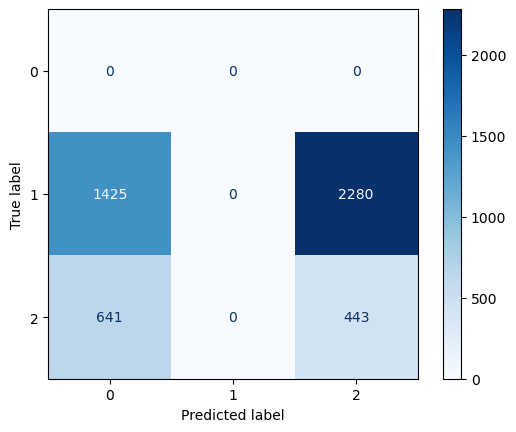

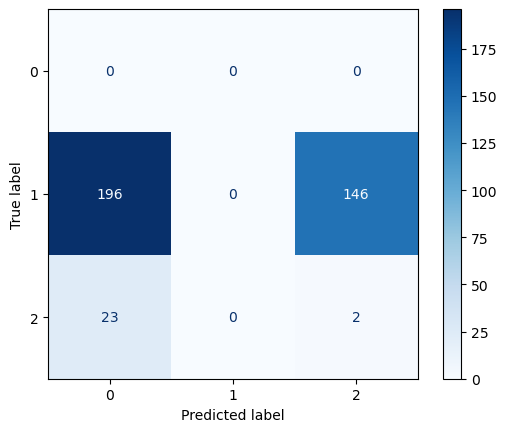

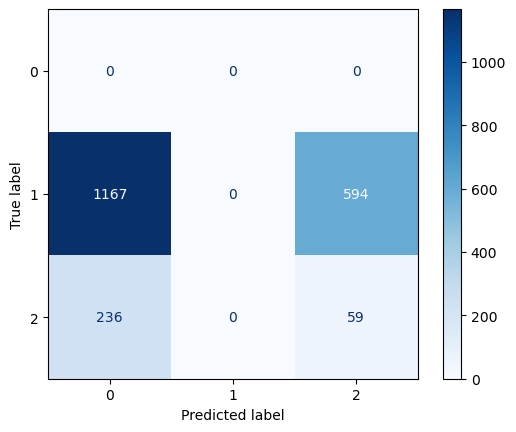

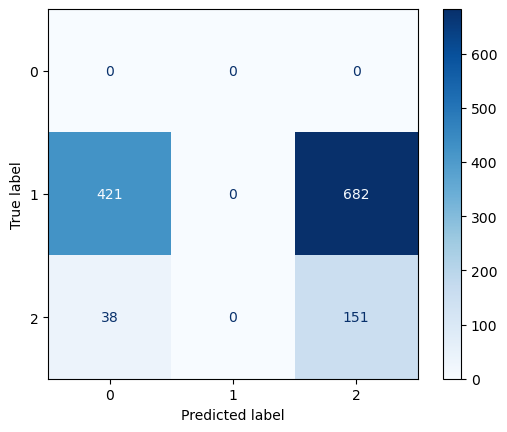

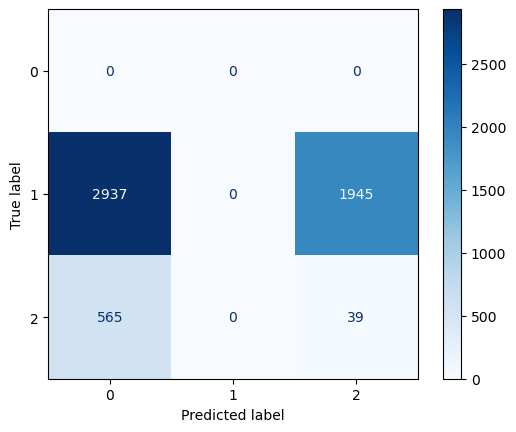

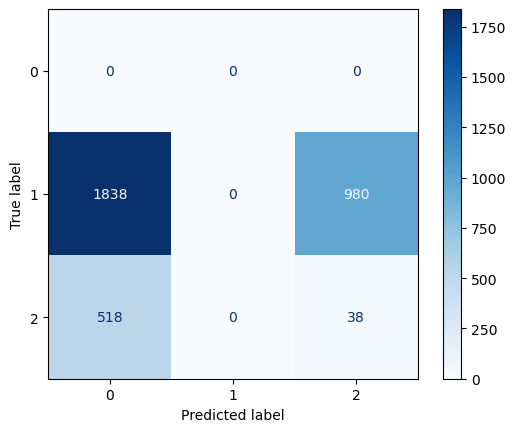

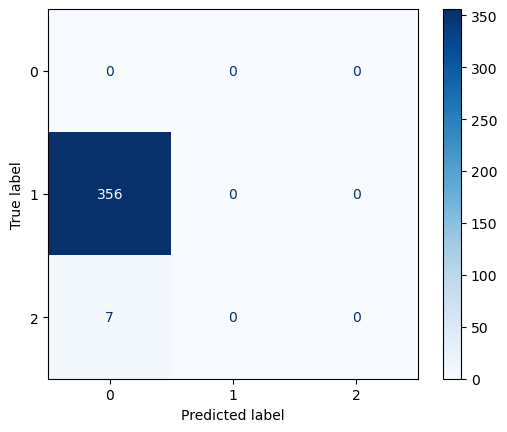

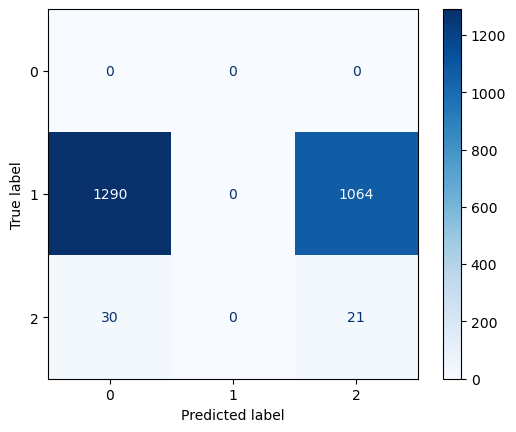

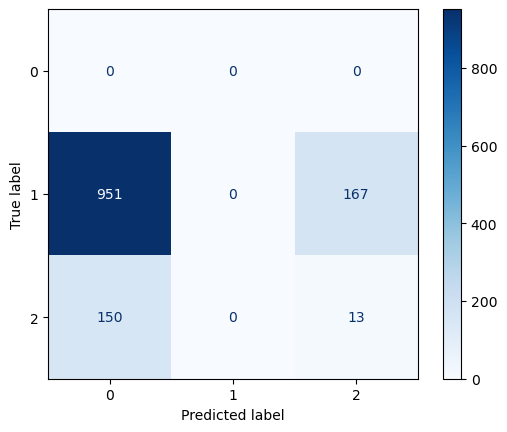

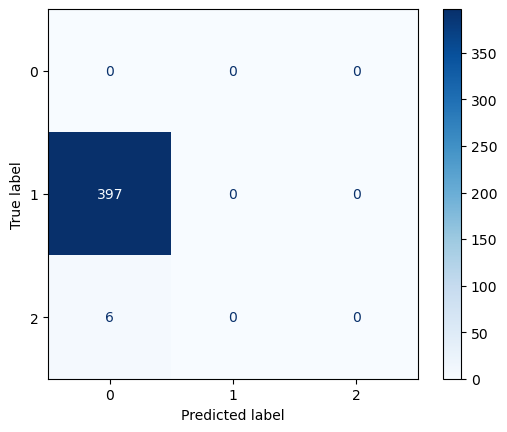

In [20]:
for channel in X_fit_train_collection:
    X_fit_train = X_fit_train_collection[channel]
    X_fit_test = X_fit_test_collection[channel]
    y_test = y_true_label_collection[channel]
    
    # Convert labels: sklearn's OneClassSVM outputs 1 for inliers and -1 for outliers
    # We need to adjust our labels accordingly (0 -> 1, 1 -> -1) for comparison
    
    clf = OneClassSVM(gamma='auto').fit(X_fit_train)
    y_pred = clf.predict(X_fit_test)
    
    print(f"Channel: {channel}")

    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_m)
    disp.plot(cmap='Blues')

## Model 2: Isolation Forest

Unsupervised anomaly detection using Isolation Forest algorithm.

Channel: D
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3705
           1       0.23      0.88      0.36      1084

    accuracy                           0.20      4789
   macro avg       0.08      0.29      0.12      4789
weighted avg       0.05      0.20      0.08      4789

FDR: 0.948957210332711
[[   0    0    0]
 [ 425    0 3280]
 [ 129    0  955]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: S
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       342
           1       0.07      0.88      0.12        25

    accuracy                           0.06       367
   macro avg       0.02      0.29      0.04       367
weighted avg       0.00      0.06      0.01       367

FDR: 0.9954448705100917
[[  0   0   0]
 [ 35   0 307]
 [  3   0  22]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: P
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1761
           1       0.15      0.96      0.25       295

    accuracy                           0.14      2056
   macro avg       0.05      0.32      0.08      2056
weighted avg       0.02      0.14      0.04      2056

FDR: 0.9789171626442982
[[   0    0    0]
 [ 118    0 1643]
 [  12    0  283]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: T
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1103
           1       0.15      1.00      0.26       189

    accuracy                           0.15      1292
   macro avg       0.05      0.33      0.09      1292
weighted avg       0.02      0.15      0.04      1292

FDR: 0.9776673402121668
[[   0    0    0]
 [  54    0 1049]
 [   0    0  189]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: E
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      4882
           1       0.11      0.91      0.20       604

    accuracy                           0.10      5486
   macro avg       0.04      0.30      0.07      5486
weighted avg       0.01      0.10      0.02      5486

FDR: 0.9879039344861018
[[   0    0    0]
 [ 434    0 4448]
 [  55    0  549]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: A
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      2818
           1       0.18      0.99      0.30       556

    accuracy                           0.16      3374
   macro avg       0.06      0.33      0.10      3374
weighted avg       0.03      0.16      0.05      3374

FDR: 0.9709873827744686
[[   0    0    0]
 [ 230    0 2588]
 [   3    0  553]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: R
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       356
           1       0.02      1.00      0.04         7

    accuracy                           0.02       363
   macro avg       0.01      0.33      0.01       363
weighted avg       0.00      0.02      0.00       363

FDR: 0.9996041459651164
[[  0   0   0]
 [ 22   0 334]
 [  0   0   7]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: G
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      2354
           1       0.02      0.90      0.04        51

    accuracy                           0.02      2405
   macro avg       0.01      0.30      0.01      2405
weighted avg       0.00      0.02      0.00      2405

FDR: 0.999519237173254
[[   0    0    0]
 [ 371    0 1983]
 [   5    0   46]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: F
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1118
           1       0.13      0.98      0.23       163

    accuracy                           0.12      1281
   macro avg       0.04      0.33      0.08      1281
weighted avg       0.02      0.12      0.03      1281

FDR: 0.9831541630998368
[[   0    0    0]
 [  76    0 1042]
 [   4    0  159]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

Channel: B
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       397
           1       0.02      1.00      0.03         6

    accuracy                           0.01       403
   macro avg       0.01      0.33      0.01       403
weighted avg       0.00      0.01      0.00       403

FDR: 0.9997630503320586
[[  0   0   0]
 [ 26   0 371]
 [  0   0   6]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/sit

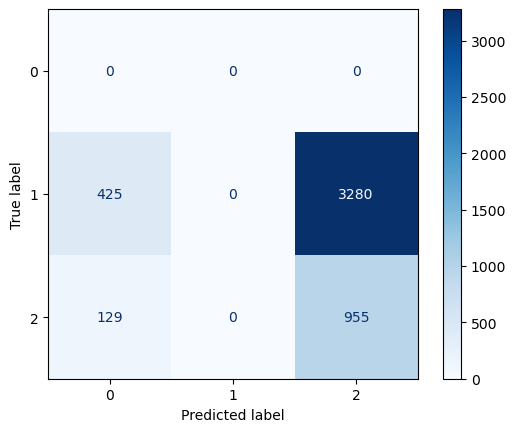

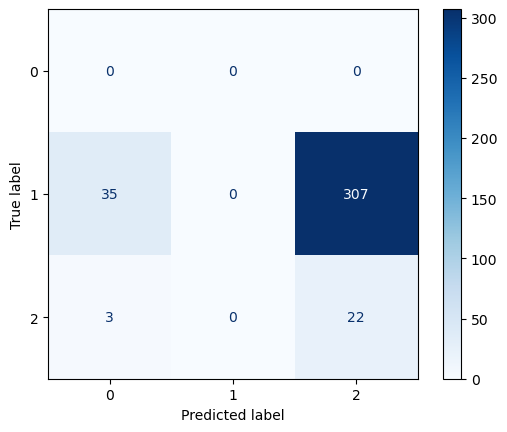

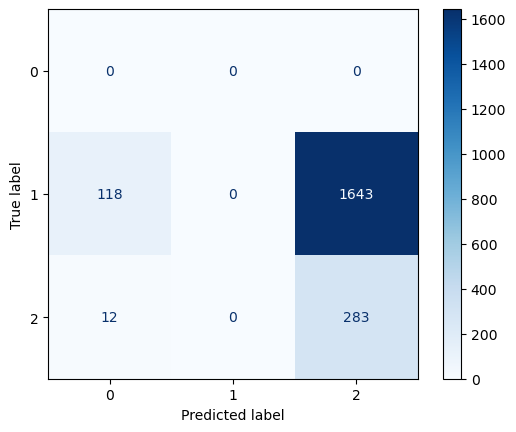

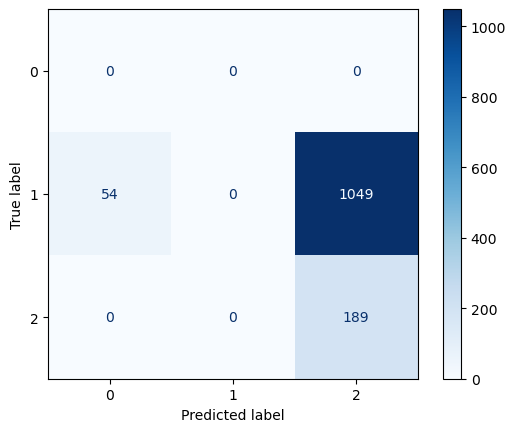

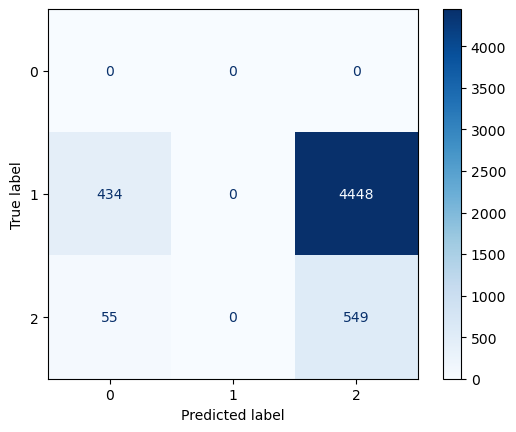

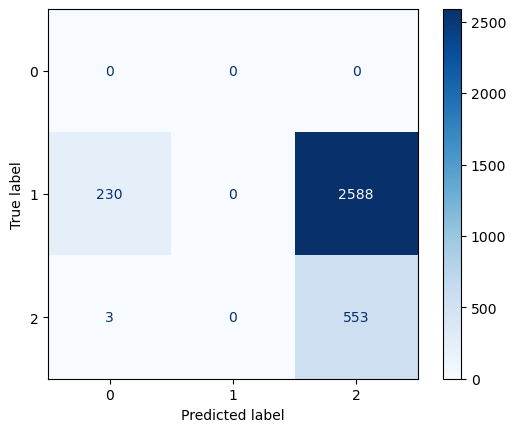

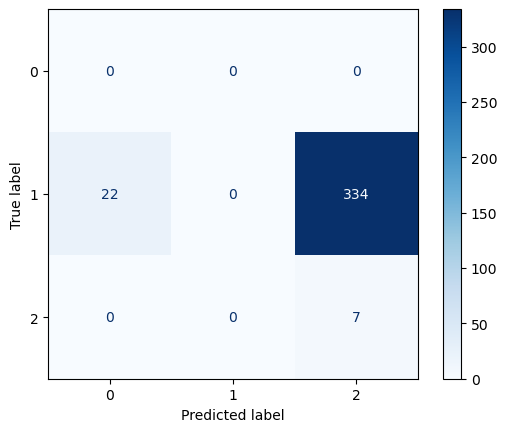

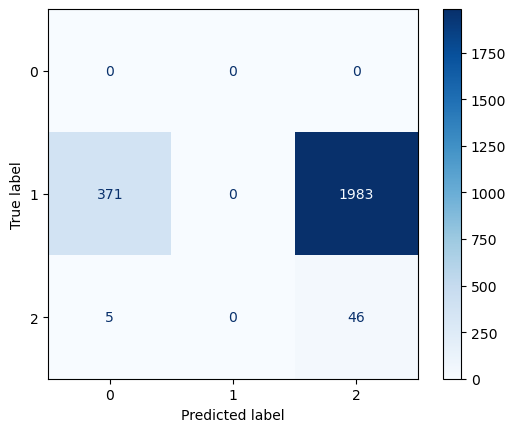

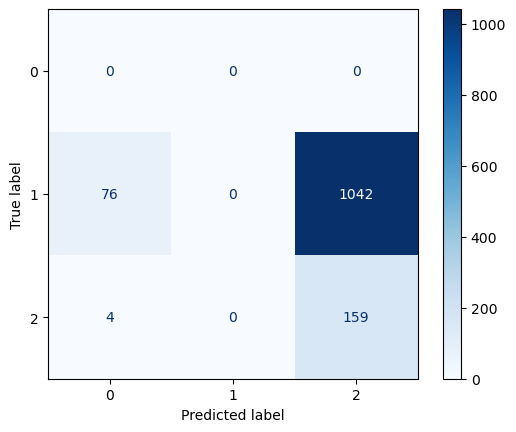

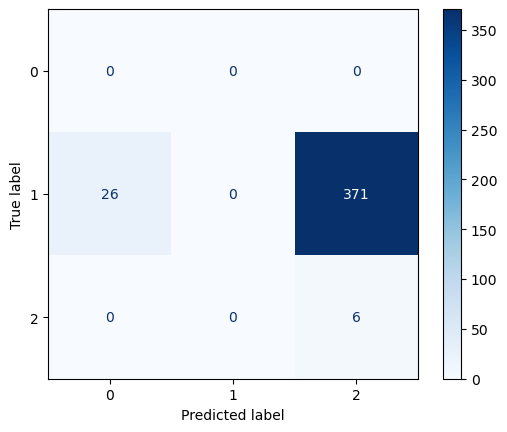

In [21]:
for channel in X_transform_train_collection:
    X_transform_train = X_transform_train_collection[channel]
    X_transform_test = X_transform_test_collection[channel]
    y_test = y_true_label_collection[channel]
    
    clf = IsolationForest(random_state=0).fit(X_transform_train)
    y_pred = clf.predict(X_transform_test)
    
    print(f"Channel: {channel}")

    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_m)
    disp.plot(cmap='Blues')

## Model 3: Local Outlier Factor (KNN-based)

Distance-based anomaly detection using k-nearest neighbours.

Channel: D - Local Outlier Factor (KNN-based)
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3705
           1       0.23      0.94      0.37      1084

    accuracy                           0.21      4789
   macro avg       0.08      0.31      0.12      4789
weighted avg       0.05      0.21      0.08      4789

FDR: 0.9471047698156314
[[   0    0    0]
 [ 370    0 3335]
 [  67    0 1017]]
Channel: S - Local Outlier Factor (KNN-based)
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       342
           1       0.04      0.52      0.07        25

    accuracy                           0.04       367
   macro avg       0.01      0.17      0.02       367
weighted avg       0.00      0.04      0.00       367

FDR: 0.9974552914278556
[[  0   0   0]
 [  7   0 335]
 [ 12   0  13

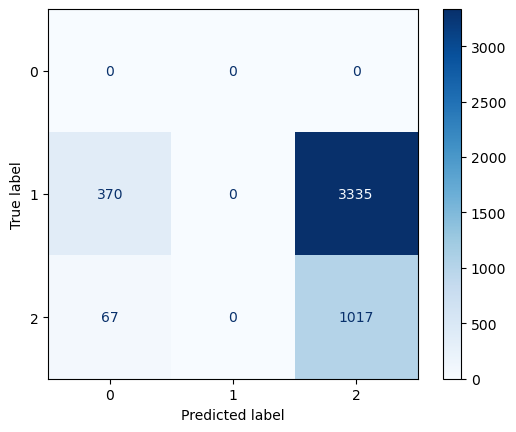

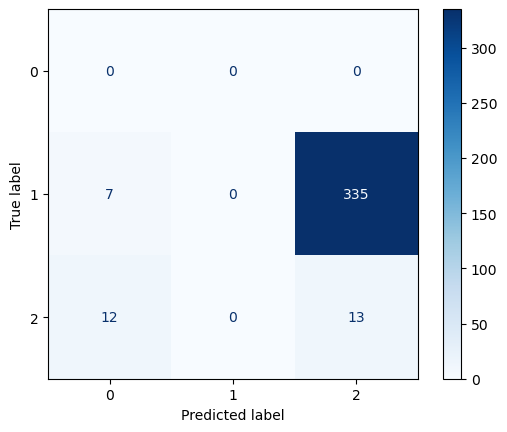

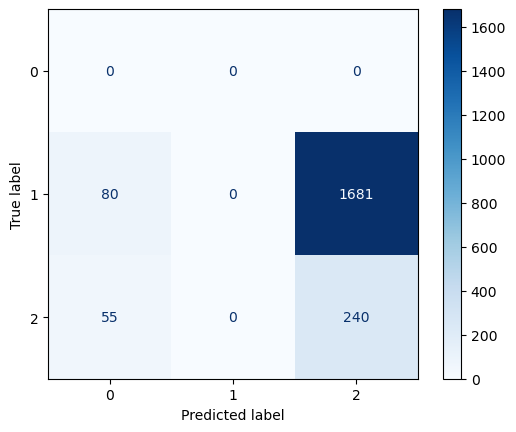

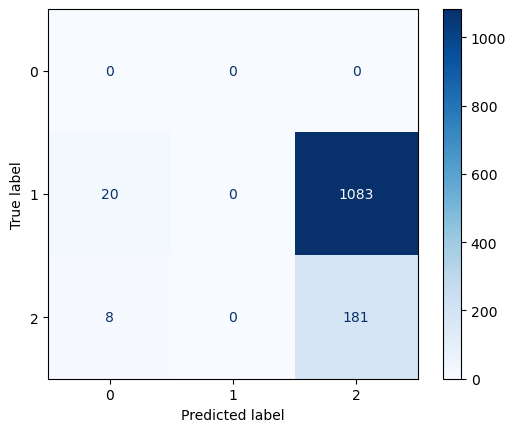

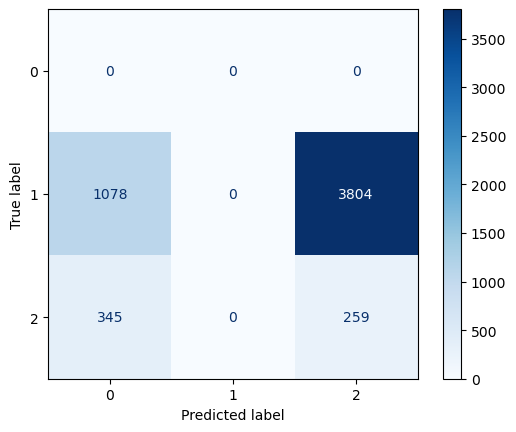

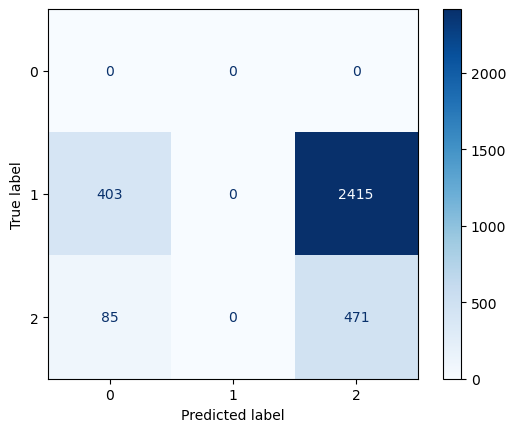

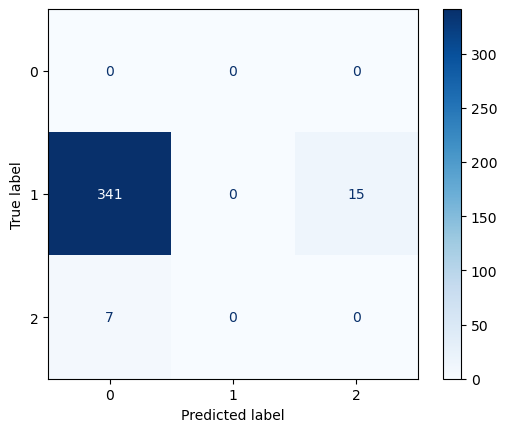

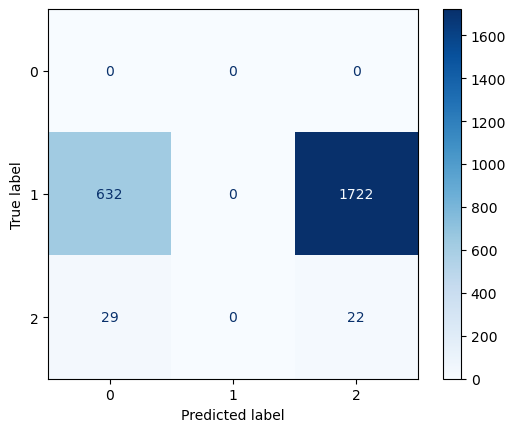

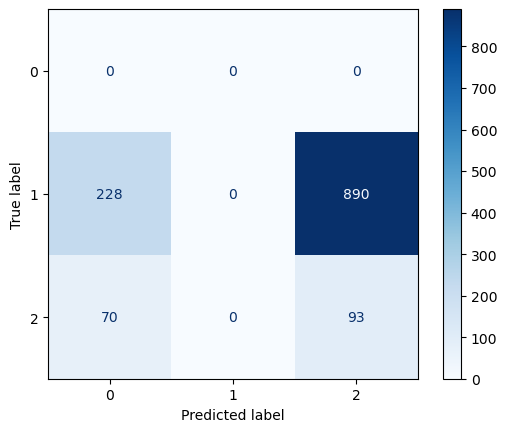

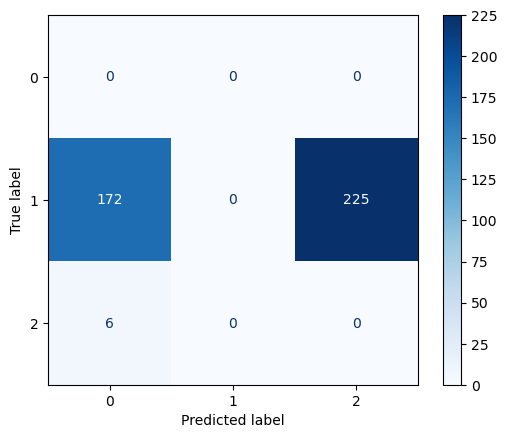

In [22]:
# Implement KNN (Local Outlier Factor) for anomaly detection
for channel in X_fit_train_collection:
    X_fit_train = X_fit_train_collection[channel]
    X_fit_test = X_fit_test_collection[channel]
    y_test = y_true_label_collection[channel]
    
    # LOF is used for outlier detection (novelty=True allows predict on new data)
    clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination='auto')
    clf.fit(X_fit_train)
    y_pred = clf.predict(X_fit_test)
    
    print(f"Channel: {channel} - Local Outlier Factor (KNN-based)")

    print(classification_report(y_test, y_pred, zero_division=0))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_m)
    disp.plot(cmap='Blues')


## Hyperparameter Tuning: One-Class SVM

Grid search for optimal SVM parameters (nu, gamma, kernel).

Channel: D - Grid Search for OneClassSVM
Testing 4 parameter combinations...
  [1/4] Testing nu=0.05, gamma=scale, kernel=rbf...New best score: 21.8412
  [2/4] Testing nu=0.05, gamma=0.01, kernel=rbf...New best score: 21.8412
  [2/4] Testing nu=0.05, gamma=0.01, kernel=rbf...Score: 0.5595
  [3/4] Testing nu=0.1, gamma=scale, kernel=rbf...Score: 0.5595
  [3/4] Testing nu=0.1, gamma=scale, kernel=rbf...New best score: 47.4383
  [4/4] Testing nu=0.1, gamma=0.01, kernel=rbf...New best score: 47.4383
  [4/4] Testing nu=0.1, gamma=0.01, kernel=rbf...Score: 1.1212

Completed in 140.53 seconds
Best parameters: {'nu': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 47.43830707842985

Classification Report with Best Parameters:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3705
           1       0.22      0.86      0.35      1084

    accuracy                           0.20      4

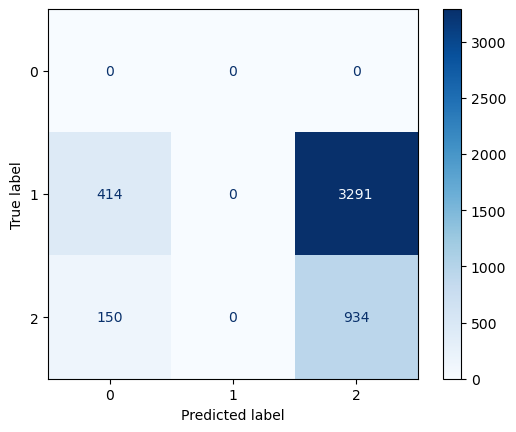

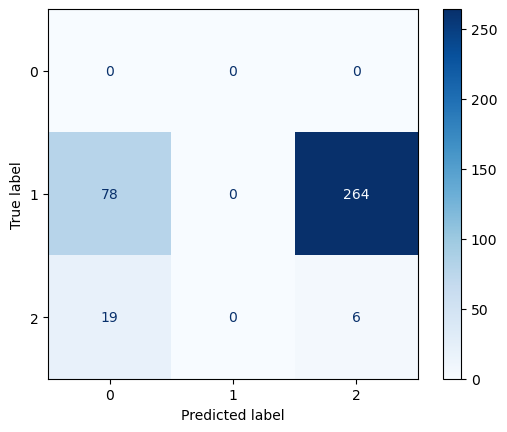

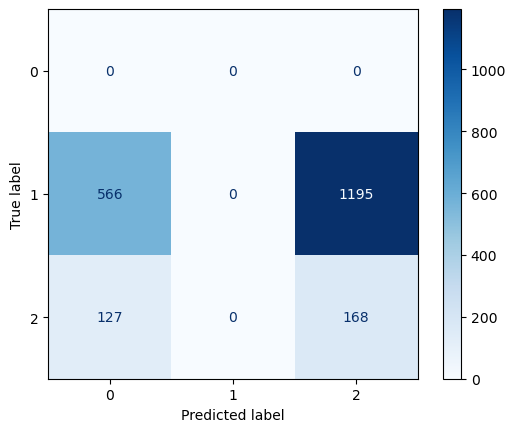

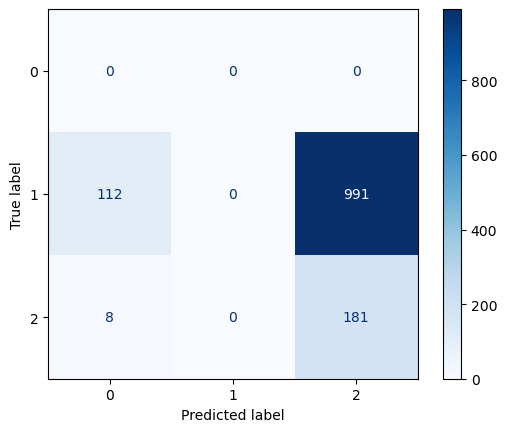

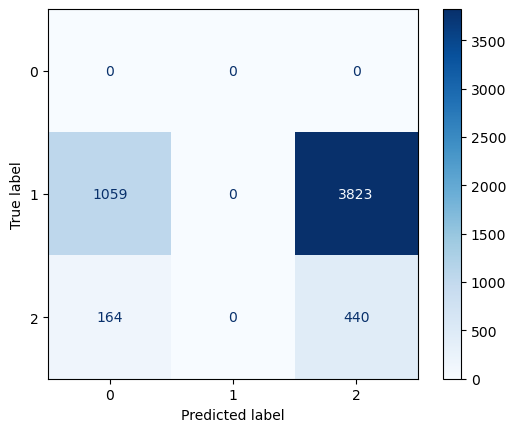

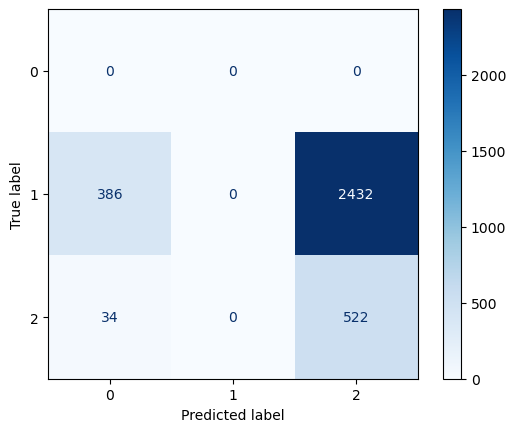

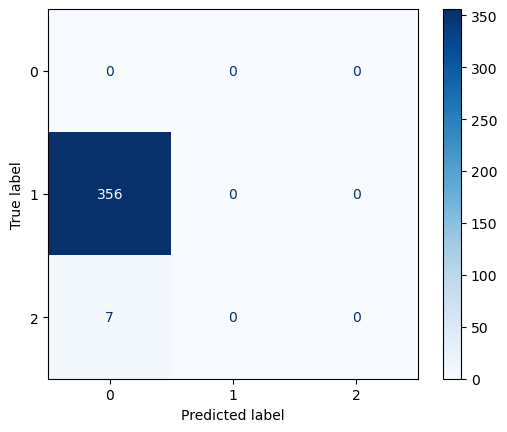

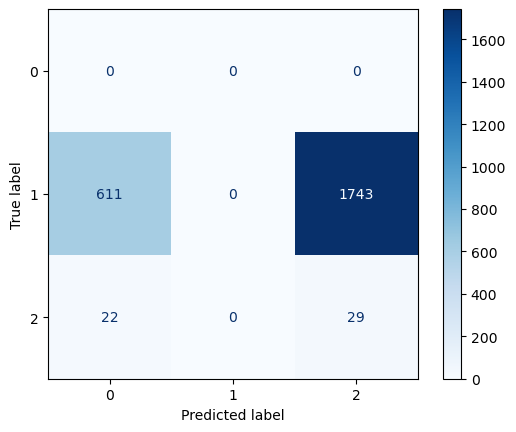

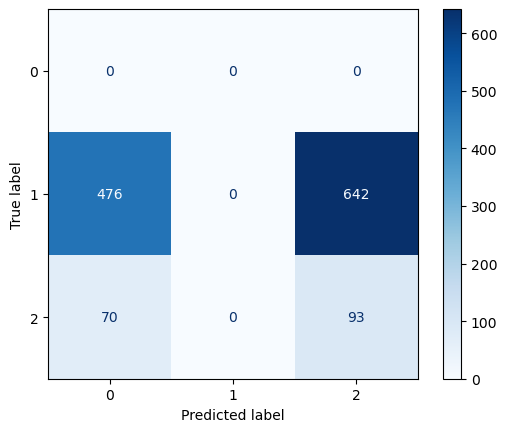

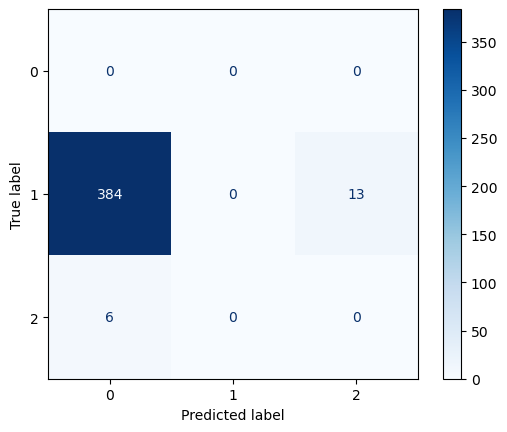

In [23]:
# Grid Search for OneClassSVM (unsupervised learning) - Optimised Version
# Reduced parameter grid for faster execution

from sklearn.metrics import make_scorer
import time

for channel in X_fit_train_collection:
    X_fit_train = X_fit_train_collection[channel]
    X_fit_test = X_fit_test_collection[channel]
    y_test = y_true_label_collection[channel]
    
    print(f"Channel: {channel} - Grid Search for OneClassSVM")
    
    best_score = -float('inf')
    best_params = {}
    best_predictions = None
    
    # Reduced parameter grid for faster execution
    param_grid = {
        'nu': [0.05, 0.1],
        'gamma': ['scale', 0.01],
        'kernel': ['rbf']
    }
    
    total_combinations = len(param_grid['nu']) * len(param_grid['gamma']) * len(param_grid['kernel'])
    current_combination = 0
    
    print(f"Testing {total_combinations} parameter combinations...")
    start_time = time.time()
    
    # Manual grid search
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:
                current_combination += 1
                try:
                    print(f"[{current_combination}/{total_combinations}] Testing nu={nu}, gamma={gamma}, kernel={kernel}...", end='')
                    
                    clf = OneClassSVM(nu=nu, gamma=gamma, kernel=kernel)
                    clf.fit(X_fit_train)
                    y_pred = clf.predict(X_fit_test)
                    
                    # Score based on decision function (higher = better)
                    score = clf.score_samples(X_fit_test).mean()
                    
                    if score > best_score:
                        best_score = score
                        best_params = {'nu': nu, 'gamma': gamma, 'kernel': kernel}
                        best_predictions = y_pred
                        print(f"New best score: {score:.4f}")
                    else:
                        print(f"Score: {score:.4f}")
                except Exception as e:
                    print(f"Failed: {e}")
                    continue
    
    elapsed_time = time.time() - start_time
    print(f"\nCompleted in {elapsed_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    print("\nClassification Report with Best Parameters:")
    print(classification_report(y_test, best_predictions, zero_division=0))
    precision = precision_score(y_test, best_predictions, average='weighted', zero_division=0)
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, best_predictions)
    print(c_m)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_m)
    disp.plot(cmap='Blues')

## Hyperparameter Tuning: Isolation Forest

Grid search for optimal Isolation Forest parameters.

Channel: D - Grid Search for Isolation Forest
Testing 4 parameter combinations...
[1/4] Testing n_est=100, samples=auto, contam=auto, feat=1.0...New best score: -0.4152
[2/4] Testing n_est=100, samples=auto, contam=0.05, feat=1.0...New best score: -0.4152
[2/4] Testing n_est=100, samples=auto, contam=0.05, feat=1.0...Score: -0.4152
[3/4] Testing n_est=100, samples=0.75, contam=auto, feat=1.0...Score: -0.4152
[3/4] Testing n_est=100, samples=0.75, contam=auto, feat=1.0...New best score: -0.3902
[4/4] Testing n_est=100, samples=0.75, contam=0.05, feat=1.0...New best score: -0.3902
[4/4] Testing n_est=100, samples=0.75, contam=0.05, feat=1.0...Score: -0.3902

Completed in 1.77 seconds
Best parameters: {'n_estimators': 100, 'max_samples': 0.75, 'contamination': 'auto', 'max_features': 1.0}
Best score: -0.39020830810276164

Classification Report with Best Parameters:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0    

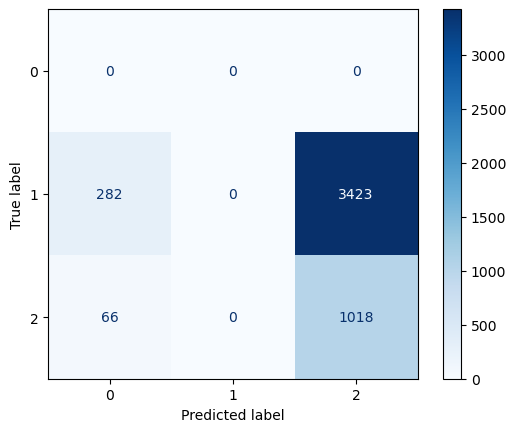

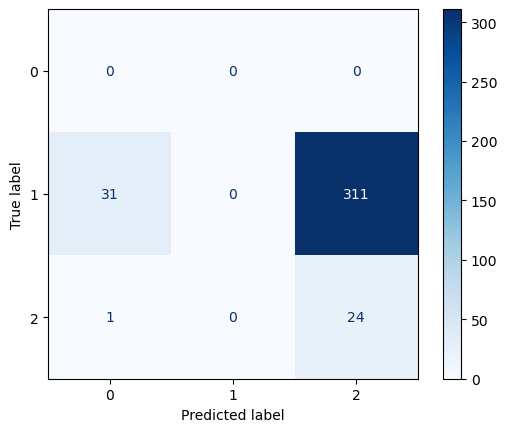

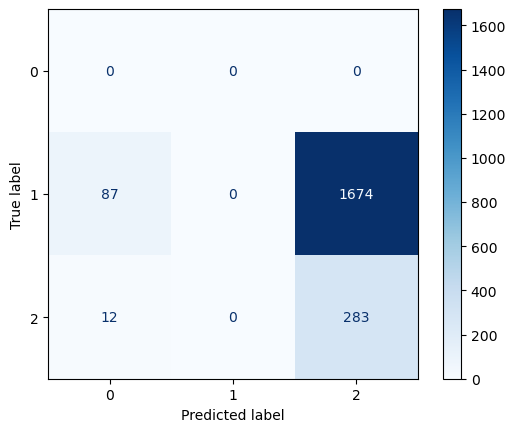

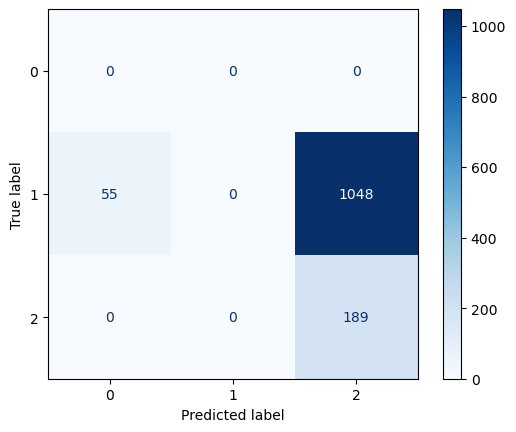

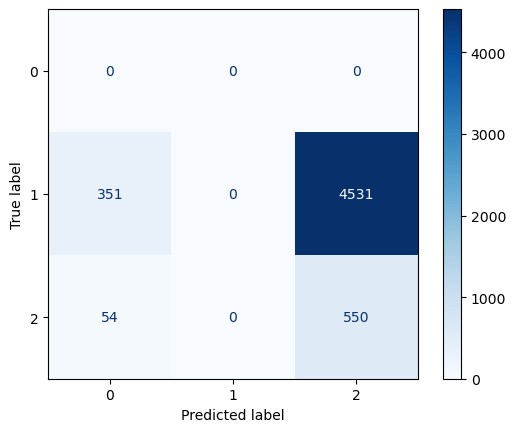

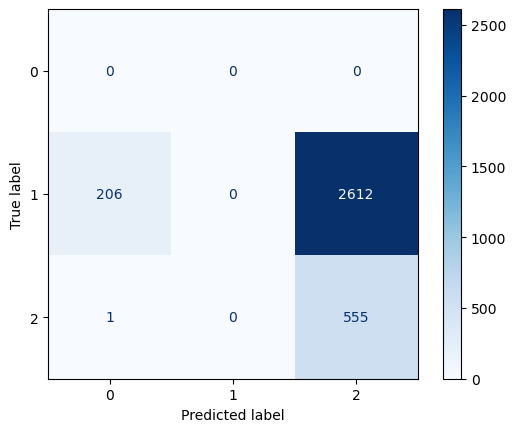

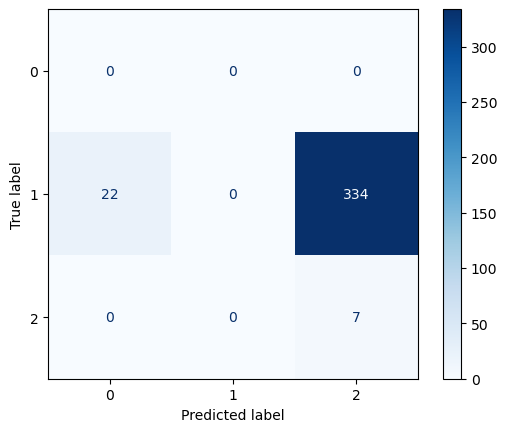

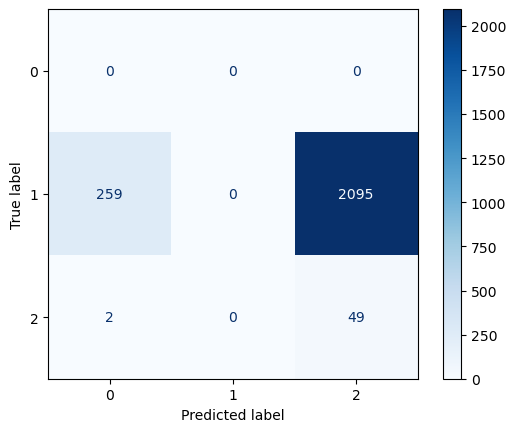

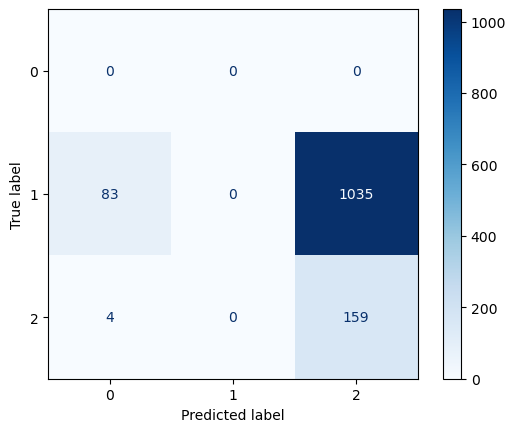

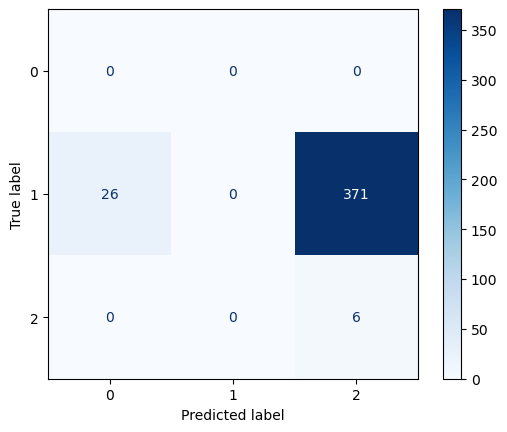

In [24]:
# Grid Search for Isolation Forest (unsupervised learning) - Optimised Version
import time

for channel in X_transform_train_collection:
    X_transform_train = X_transform_train_collection[channel]
    X_transform_test = X_transform_test_collection[channel]
    y_test = y_true_label_collection[channel]
    
    print(f"Channel: {channel} - Grid Search for Isolation Forest")

    
    best_score = -float('inf')
    best_params = {}
    best_predictions = None
    
    # Reduced parameter grid for faster execution
    param_grid = {
        'n_estimators': [100],
        'max_samples': ['auto', 0.75],
        'contamination': ['auto', 0.05],
        'max_features': [1.0]
    }
    
    total_combinations = (len(param_grid['n_estimators']) * len(param_grid['max_samples']) * 
                         len(param_grid['contamination']) * len(param_grid['max_features']))
    current_combination = 0
    
    print(f"Testing {total_combinations} parameter combinations...")
    start_time = time.time()
    
    # Manual grid search
    for n_estimators in param_grid['n_estimators']:
        for max_samples in param_grid['max_samples']:
            for contamination in param_grid['contamination']:
                for max_features in param_grid['max_features']:
                    current_combination += 1
                    try:
                        print(f"[{current_combination}/{total_combinations}] Testing n_est={n_estimators}, samples={max_samples}, contam={contamination}, feat={max_features}...", end='')
                        
                        clf = IsolationForest(
                            n_estimators=n_estimators,
                            max_samples=max_samples,
                            contamination=contamination,
                            max_features=max_features,
                            random_state=42
                        )
                        clf.fit(X_transform_train)
                        y_pred = clf.predict(X_transform_test)
                        
                        # Score based on decision function (higher = better)
                        score = clf.score_samples(X_transform_test).mean()
                        
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'n_estimators': n_estimators,
                                'max_samples': max_samples,
                                'contamination': contamination,
                                'max_features': max_features
                            }
                            best_predictions = y_pred
                            print(f"New best score: {score:.4f}")
                        else:
                            print(f"Score: {score:.4f}")
                    except Exception as e:
                        print(f" Failed: {e}")
                        continue
    
    elapsed_time = time.time() - start_time
    print(f"\nCompleted in {elapsed_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    print("\nClassification Report with Best Parameters:")
    print(classification_report(y_test, best_predictions, zero_division=0))
    precision = precision_score(y_test, best_predictions, average='weighted', zero_division=0)
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, best_predictions)
    print(c_m)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_m)
    disp.plot(cmap='Blues')